# MLS Player Performance Review


In [1]:
#Image(url='https://upload.wikimedia.org/wikipedia/commons/thumb/7/76/MLS_crest_logo_RGB_gradient.svg/440px-MLS_crest_logo_RGB_gradient.svg.png')

## Overview

Major League Soccer (MLS) has been keeping data on its players for years and would like to utilize that data to evaluate player performance and its relationship to player salary. By anazlying this data , I hope to create a predictive model that can highlight this link and the particular aspects of player performance that are most tied to salary. 

## Business Problem

MLS has growing rapidly and gaining in popularity, increasing their number of teams from just 13 in 2007 to 29 today. Likewise, the average team revenue increased from  37 million USD in 2008 to 582 million USD in 2022. This also saw an increase in player salary over the years. In order to figure out what a player's salary should be, I analyzed a player's statistics by year in order to come up with recommendations to further bolster future analysis.

## Data Understanding
The statistics datasets in this analysis come from Mlssoccer.com, provided by (Kaggle Dataset) via webscraping before the website changed how it displayed information. The salary datasets come directly from the MLSPA(Major League Soccer Players Association) on mlsplayers.org. I analyzed XXXX players from the combined dataframe of these sources ranging from 2007-2022.

The statsistics datasets were csv files containing information about a field player's and goalkeeper's performance on field during a season. The field player's dataset includes information such as goals, assists, games played, total minutes played, and more. the goalkeeper's dataset included some similar information such as games played and total minutes played, but also contained unique statistics like saves, goals conceded, and wins, losses, and ties.



## Data Preparation

MLS wants to continue to expand and entice players the likes of Lionel Messi into the league. In order to understand the current salaries of players in the league, I combined the statistics and salary datasets.

I trained a Linear Regression Model, Random Forest Regression Model, and KNearestNeighbors Regression Model. I utilized a Pipeline and GridSearch for each of these to crossvalidate scores and iterate over many different models. I added and modified several feature columns, including Penaly Kick Conversion Rates, whether a player made the Postseason, a one-hot encoded breakdown of player position, and more. My final dataframe contained XX features that were used by these models to more accurately predict Player salary. I used r2 score, MSE, RMSE, and MAE to help evaluate how well my models were performing, but ultimately looked at r2 score and RMSE as my most important metrics to measure how far off a model was predicting salary. 

### Imports

In [335]:
import pandas as pd
import os
from rapidfuzz import fuzz
import re
from unidecode import unidecode
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.datasets import make_blobs
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score, silhouette_score, mean_squared_error, mean_absolute_error 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from IPython.display import Image
from sklearn.inspection import permutation_importance

### Reading Data
These datasets are directly inside the repository and are accessed using the below code.

In [3]:
# Loading csv files into dataframes
player_stats_df = pd.read_csv('./data/Player_stats/all_players.csv')
keeper_stats_df = pd.read_csv('./data/Player_stats/all_goalkeepers.csv')

### Data Cleaning


In [4]:
# PKG/A needs to be changed as it is fractions in the form of strings.
keeper_stats_df.head()

,Player,Club,POS,GP,GS,MINS,SHTS,SV,GA,GAA,PKG/A,W,L,T,ShO,W%,Sv%,Year,Season
0,Mark Dodd,DAL,GK,31,31,2776,235,160,45,1.45,5/5,17,14,0,6,54.8,68.1,1996,reg
1,Tony Meola,MET,GK,29,29,2610,188,142,38,1.31,3/4,14,15,0,9,48.3,75.5,1996,reg
2,Mark Dougherty,TB,GK,28,28,2520,186,123,47,1.68,9/10,17,11,0,3,60.7,66.1,1996,reg
3,Jorge Campos,LA,GK,24,24,2160,133,100,27,1.13,0/1,13,8,0,4,54.2,75.2,1996,reg
4,Garth Lagerwey,KC,GK,23,22,1959,133,83,38,1.73,2/2,12,10,0,3,52.2,62.4,1996,reg


In [5]:
# Will be dropping Club, so no nulls to deal with in this dataframe
keeper_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  2006 non-null   object 
 1   Club    1324 non-null   object 
 2   POS     2006 non-null   object 
 3   GP      2006 non-null   int64  
 4   GS      2006 non-null   int64  
 5   MINS    2006 non-null   int64  
 6   SHTS    2006 non-null   int64  
 7   SV      2006 non-null   int64  
 8   GA      2006 non-null   int64  
 9   GAA     2006 non-null   float64
 10  PKG/A   2006 non-null   object 
 11  W       2006 non-null   int64  
 12  L       2006 non-null   int64  
 13  T       2006 non-null   int64  
 14  ShO     2006 non-null   int64  
 15  W%      2006 non-null   float64
 16  Sv%     2006 non-null   float64
 17  Year    2006 non-null   int64  
 18  Season  2006 non-null   object 
dtypes: float64(3), int64(11), object(5)
memory usage: 297.9+ KB


In [6]:
keeper_stats_df.describe()

,GP,GS,MINS,SHTS,SV,GA,GAA,W,L,T,ShO,W%,Sv%,Year
count,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000
mean,6.804586,6.677966,603.997009,33.926720,23.310568,9.608175,0.888500,2.629611,2.626620,1.420738,1.606680,18.861316,37.418096,2010.110668
std,10.316232,10.292286,924.747438,52.330135,36.569597,14.673335,0.992154,4.433369,4.090945,2.753633,2.855163,24.494023,34.628706,7.284097
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1996.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2004.000000
50%,1.000000,1.000000,90.000000,7.000000,4.000000,2.000000,0.940000,0.000000,1.000000,0.000000,0.000000,0.000000,52.700000,2011.000000
75%,9.000000,8.000000,770.250000,47.000000,31.000000,13.750000,1.500000,3.000000,3.000000,1.000000,2.000000,37.500000,68.900000,2016.750000
max,34.000000,34.000000,3060.000000,249.000000,184.000000,64.000000,6.000000,22.000000,19.000000,18.000000,16.000000,100.000000,100.000000,2020.000000


In [7]:
player_stats_df.head()

,Player,Club,POS,GP,GS,MINS,G,A,SHTS,SOG,...,RdA,A/90min,FC,FS,OFF,YC,RC,SOG%,Year,Season
0,Roy Lassiter,TB,F,30,30,2580,27,4,76,49,...,2,0.14,20,39,70,2,0,64.47,1996,reg
1,Raul Diaz Arce,DC,F,28,28,2351,23,2,100,49,...,2,0.08,32,26,35,6,1,49.00,1996,reg
2,Eduardo Hurtado,LA,F,26,26,2323,21,7,87,56,...,3,0.27,48,26,25,5,0,64.37,1996,reg
3,Preki,KC,M,32,32,2880,18,13,140,61,...,4,0.41,26,44,7,3,0,43.57,1996,reg
4,Brian McBride,CLB,F,28,28,2307,17,3,79,44,...,1,0.12,21,46,10,0,0,55.70,1996,reg


In [8]:
#A lot of columns to sift through, but no nulls to deal with since we will be dropping club. 
player_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15767 entries, 0 to 15766
Data columns (total 28 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Player   15767 non-null  object 
 1   Club     10274 non-null  object 
 2   POS      15767 non-null  object 
 3   GP       15767 non-null  int64  
 4   GS       15767 non-null  int64  
 5   MINS     15767 non-null  int64  
 6   G        15767 non-null  int64  
 7   A        15767 non-null  int64  
 8   SHTS     15767 non-null  int64  
 9   SOG      15767 non-null  int64  
 10  GWG      15767 non-null  int64  
 11  PKG/A    15767 non-null  object 
 12  HmG      15767 non-null  int64  
 13  RdG      15767 non-null  int64  
 14  G/90min  15767 non-null  float64
 15  SC%      15767 non-null  float64
 16  GWA      15767 non-null  int64  
 17  HmA      15767 non-null  int64  
 18  RdA      15767 non-null  int64  
 19  A/90min  15767 non-null  float64
 20  FC       15767 non-null  int64  
 21  FS       157

I had to filter the statistics dataframe down to just the years 2007-2020 since that is the furthest back I was able to access
salary data. Consequently it is also the year the Designated Player rule (commonly referred to as the "Beckham rule" ) was first implemented; it is credited as the most important catalyst that spurred the beginning of the rapid expansion of MLS. 

In [9]:
#Creating a list of the years we want to use from the dataframes. Salary data is only accessible back to 2007.
years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [10]:
#Filtering dataframes to only show years in the years list
player_stats_df = player_stats_df[player_stats_df['Year'].isin(years)]
keeper_stats_df = keeper_stats_df[keeper_stats_df['Year'].isin(years)]

In [11]:
player_stats_df

,Player,Club,POS,GP,GS,MINS,G,A,SHTS,SOG,...,RdA,A/90min,FC,FS,OFF,YC,RC,SOG%,Year,Season
3029,Luciano Emilio,DC,F,29,28,2410,20,1,79,47,...,0,0.04,35,39,21,2,0,59.49,2007,reg
3030,Juan Pablo Angel,NY,F,24,24,2125,19,5,97,53,...,2,0.21,31,20,42,2,1,54.64,2007,reg
3031,Taylor Twellman,NE,F,26,25,2283,16,3,90,55,...,1,0.12,13,41,21,2,0,61.11,2007,reg
3032,Eddie Johnson,KC,F,24,24,2149,15,6,75,43,...,3,0.25,21,57,50,6,0,57.33,2007,reg
3033,Maykel Galindo,CHV,F,28,24,2021,12,5,55,28,...,2,0.22,44,53,30,6,0,50.91,2007,reg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15762,Alejandro Pozuelo,NaN,M,1,1,120,0,0,5,0,...,0,0.00,2,0,0,0,0,0.00,2020,post
15763,Franco Jara,NaN,F,2,2,210,0,0,5,1,...,0,0.00,6,2,3,0,0,20.00,2020,post
15764,Andy Polo,NaN,M,1,1,105,0,0,6,3,...,0,0.00,0,3,0,0,0,50.00,2020,post
15765,Cristian Roldan,NaN,M,4,4,360,0,0,6,1,...,0,0.00,5,11,0,0,0,16.67,2020,post


In [12]:
player_stats_df['Season'].value_counts()

Season
reg     7245
post    3727
Name: count, dtype: int64

I'm going to remove the season column here but before I do that would like to add a feature that tells whether a player made it to the postseason or not. *(If they did do I add their postseason statistics in? What are the arguments for and against?)

In [13]:
grouped = player_stats_df.groupby(['Player', 'Year'])
made_postseason = grouped['Season'].nunique()

made_postseason = made_postseason.reset_index()
made_postseason.columns = ['Player', 'Year', 'Postseason']

player_stats_df = player_stats_df.merge(made_postseason, on=['Player', 'Year'])
player_stats_df['Postseason'] = player_stats_df['Postseason'].map({2:1, 1:0})
player_stats_df


,Player,Club,POS,GP,GS,MINS,G,A,SHTS,SOG,...,A/90min,FC,FS,OFF,YC,RC,SOG%,Year,Season,Postseason
0,Luciano Emilio,DC,F,29,28,2410,20,1,79,47,...,0.04,35,39,21,2,0,59.49,2007,reg,1
1,Luciano Emilio,NaN,F,2,1,77,0,0,2,2,...,0.00,0,1,0,0,0,100.00,2007,post,1
2,Juan Pablo Angel,NY,F,24,24,2125,19,5,97,53,...,0.21,31,20,42,2,1,54.64,2007,reg,1
3,Juan Pablo Angel,NaN,F,2,2,154,0,0,7,4,...,0.00,5,3,2,0,0,57.14,2007,post,1
4,Taylor Twellman,NE,F,26,25,2283,16,3,90,55,...,0.12,13,41,21,2,0,61.11,2007,reg,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10967,Siem de Jong,CIN,M,15,8,793,0,0,18,5,...,0.00,7,8,1,0,0,27.78,2020,reg,0
10968,Maxime Chanot,NYC,D,20,20,1712,0,0,19,4,...,0.00,18,6,1,5,1,21.05,2020,reg,1
10969,Maxime Chanot,NaN,D,1,1,120,1,0,2,1,...,0.00,1,1,0,0,0,50.00,2020,post,1
10970,Nicolas Figal,MIA,D,21,21,1746,0,0,22,9,...,0.00,22,26,0,4,0,40.91,2020,reg,1


In [14]:
k_grouped = keeper_stats_df.groupby(['Player', 'Year'])
made_postseason = k_grouped['Season'].nunique()

made_postseason = made_postseason.reset_index()
made_postseason.columns = ['Player', 'Year', 'Postseason']

keeper_stats_df = keeper_stats_df.merge(made_postseason, on=['Player', 'Year'])
keeper_stats_df['Postseason'] = keeper_stats_df['Postseason'].map({2:1, 1:0})
keeper_stats_df

,Player,Club,POS,GP,GS,MINS,SHTS,SV,GA,GAA,PKG/A,W,L,T,ShO,W%,Sv%,Year,Season,Postseason
0,Bouna Coundoul,COL,GK,30,30,2668,158,120,32,1.07,2/2,9,12,8,9,30.0,75.9,2007,reg,0
1,Kevin Hartman,KC,GK,30,30,2700,159,110,45,1.50,6/7,11,12,7,5,36.7,69.2,2007,reg,1
2,Kevin Hartman,NaN,GK,3,3,270,17,14,2,0.67,0/0,1,1,1,2,33.3,82.4,2007,post,1
3,Matt Reis,NE,GK,30,30,2700,169,120,43,1.43,3/3,14,8,8,10,46.7,71.0,2007,reg,1
4,Matt Reis,NaN,GK,4,4,360,27,24,2,0.50,0/0,2,1,1,3,50.0,88.9,2007,post,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1358,Elliot Panicco,NaN,GK,0,0,0,0,0,0,0.00,0/0,0,0,0,0,0.0,0.0,2020,post,1
1359,Eric Dick,SKC,GK,0,0,0,0,0,0,0.00,0/0,0,0,0,0,0.0,0.0,2020,reg,1
1360,Eric Dick,NaN,GK,0,0,0,0,0,0,0.00,0/0,0,0,0,0,0.0,0.0,2020,post,1
1361,Stefan Cleveland,SEA,GK,0,0,0,0,0,0,0.00,0/0,0,0,0,0,0.0,0.0,2020,reg,1


I am removing postseason data from the dataset as it is a smaller subset and effectively duplicates players that made it to the postseason for that particular year.

In [15]:
# Filtering dataframes to only have data from the regular season
player_stats_df = player_stats_df[player_stats_df['Season'] == 'reg']
keeper_stats_df = keeper_stats_df[keeper_stats_df['Season'] == 'reg']

In [16]:
player_stats_df

,Player,Club,POS,GP,GS,MINS,G,A,SHTS,SOG,...,A/90min,FC,FS,OFF,YC,RC,SOG%,Year,Season,Postseason
0,Luciano Emilio,DC,F,29,28,2410,20,1,79,47,...,0.04,35,39,21,2,0,59.49,2007,reg,1
2,Juan Pablo Angel,NY,F,24,24,2125,19,5,97,53,...,0.21,31,20,42,2,1,54.64,2007,reg,1
4,Taylor Twellman,NE,F,26,25,2283,16,3,90,55,...,0.12,13,41,21,2,0,61.11,2007,reg,1
6,Eddie Johnson,KC,F,24,24,2149,15,6,75,43,...,0.25,21,57,50,6,0,57.33,2007,reg,1
8,Maykel Galindo,CHV,F,28,24,2021,12,5,55,28,...,0.22,44,53,30,6,0,50.91,2007,reg,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10963,Sebastian Mendez,ORL,M,19,11,1087,0,0,17,3,...,0.00,32,9,1,4,1,17.65,2020,reg,1
10965,Kelyn Rowe,NE,M,16,10,896,0,0,17,4,...,0.00,13,4,0,3,0,23.53,2020,reg,1
10967,Siem de Jong,CIN,M,15,8,793,0,0,18,5,...,0.00,7,8,1,0,0,27.78,2020,reg,0
10968,Maxime Chanot,NYC,D,20,20,1712,0,0,19,4,...,0.00,18,6,1,5,1,21.05,2020,reg,1


In [17]:
keeper_stats_df

,Player,Club,POS,GP,GS,MINS,SHTS,SV,GA,GAA,PKG/A,W,L,T,ShO,W%,Sv%,Year,Season,Postseason
0,Bouna Coundoul,COL,GK,30,30,2668,158,120,32,1.07,2/2,9,12,8,9,30.0,75.9,2007,reg,0
1,Kevin Hartman,KC,GK,30,30,2700,159,110,45,1.50,6/7,11,12,7,5,36.7,69.2,2007,reg,1
3,Matt Reis,NE,GK,30,30,2700,169,120,43,1.43,3/3,14,8,8,10,46.7,71.0,2007,reg,1
5,Joe Cannon,LA,GK,29,29,2610,171,119,46,1.59,4/5,9,13,7,5,31.0,69.6,2007,reg,0
6,Troy Perkins,DC,GK,29,29,2610,155,117,32,1.10,1/3,16,6,7,8,55.2,75.5,2007,reg,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,Emmanuel Ochoa,SJ,GK,0,0,0,0,0,0,0.00,0/0,0,0,0,0,0.0,0.0,2020,reg,1
1355,Drake Callender,MIA,GK,0,0,0,0,0,0,0.00,0/0,0,0,0,0,0.0,0.0,2020,reg,1
1357,Elliot Panicco,NSH,GK,0,0,0,0,0,0,0.00,0/0,0,0,0,0,0.0,0.0,2020,reg,1
1359,Eric Dick,SKC,GK,0,0,0,0,0,0,0.00,0/0,0,0,0,0,0.0,0.0,2020,reg,1


The bulk of the data cleaning comes in for the salary dataframes which I am loading in here. I first identified what differences in column names the datasets had and got them to a place of uniformity.

In [18]:
# Loading in all the salary datasets into respective dataframes
salary2007_df = pd.read_excel('./data/Salary_data/2007-Salaries.xlsx', header=0)
salary2008_df = pd.read_excel('./data/Salary_data/2008-Salaries.xlsx', header=0)
salary2009_df = pd.read_excel('./data/Salary_data/2009-Salaries.xlsx', header=0)
salary2010_df = pd.read_excel('./data/Salary_data/2010-Salaries.xlsx', header=0)
salary2011_df = pd.read_excel('./data/Salary_data/2011-Salaries.xlsx', header=1)
salary2012_df = pd.read_excel('./data/Salary_data/2012-Salaries.xlsx', header=1)
salary2013_df = pd.read_excel('./data/Salary_data/2013-Salaries.xlsx', header=1)
salary2014_df = pd.read_excel('./data/Salary_data/2014-Salaries.xlsx', header=1)
salary2015_df = pd.read_excel('./data/Salary_data/2015-Salaries.xlsx', header=1)
salary2016_df = pd.read_excel('./data/Salary_data/2016-Salaries.xlsx', header=1)
salary2017_df = pd.read_excel('./data/Salary_data/2017-Salaries.xlsx', header=1)
salary2018_df = pd.read_excel('./data/Salary_data/2018-Salaries.xlsx', header=0)
salary2019_df = pd.read_excel('./data/Salary_data/2019-Salaries.xlsx', header=1)
salary2020_df = pd.read_excel('./data/Salary_data/2020-Salaries-.xlsx', header=0)


In [19]:
salary2007_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,DC,Addlery,Nicholas,F,36000,36000
1,LA,Albright,Chris,M-D,142500,142500
2,NY,Altidore,Josmer,F,85000,108333
3,DAL,Alvarez,Arturo,M,32819,46019
4,NY,Angel,Juan Pablo,F,1500000,1593750


In [20]:
salary2008_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,LA,Adzemian,Vardan,D,12900,12900
1,LA,Alamo,Charles,GK,12900,12900
2,NE,Albright,Chris,D,160000,160000
3,HOU,Alcaraz,Johnny,M,12900,12900
4,LA,Allen,Ely,F,12900,12900


In [21]:
salary2009_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,NE,Albright,Chris,D,176000,176000
1,RSL,Alexandre,Jean,M,34000,34000
2,DC,Allen,Ely,F-M,15300,15300
3,SEA,Alonso,Osvaldo,M,65000,65000
4,NE,Alston,Kevin,D,55000,104000


In [22]:
salary2010_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,NY,Agudelo,Juan,F,40000,70000
1,KC,Aiyegbusi,Olukorede,D,40000,40000
2,COL,Akpan,Andre,F,40000,65000
3,NY,Albright,Chris,D,84000,84000
4,DAL,Alexander,Eric,M,40000,40000


In [23]:
salary2011_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,COL,Ababio,Eddie,D,32604,32604
1,PHI,Adu,Freddy,M,475884,594884
2,RSL,Agorsor,Christopher,F,32604,32604
3,NY,Agudelo,Juan,F,55000,85000
4,KC,Aiyegbusi,Olukorede,D,42000,42000


In [24]:
# What is Unnamed:5 ?
salary2020_df.head()

,Last Name,First Name,2020 Fall Salary List Club,Playing Position,Base Salary,Unnamed: 5,Base Guaranteed Comp.
0,Aaronson,Brenden,Philadelphia Union,M,85000,NaN,103309
1,Abdul-Salaam,Saad,FC Cincinnati,D,81375,NaN,90042
2,Abu,Mohammed,DC United,M,81375,NaN,81375
3,Abubakar,Lalas,Colorado Rapids,D,145000,NaN,154937
4,Accam,David,Nashville SC,F,875000,NaN,1002916


In [25]:
#These are salaries. Went back into the original excel spreadsheet that the dataset is on and found that at one point
#the information for Base Salary gets split into two columns.
salary2020_df['Unnamed: 5'].value_counts()

Unnamed: 5
81375.0      8
63547.0      8
100000.0     2
155004.0     1
800000.0     1
192500.0     1
315000.0     1
525000.0     1
1457148.0    1
275000.0     1
6000000.0    1
750000.0     1
185000.0     1
500000.0     1
85000.0      1
200004.0     1
151255.0     1
166000.0     1
730008.0     1
210000.0     1
Name: count, dtype: int64

In [26]:
#filling rows with  'Base Salary' nulls with the filled in 'Unnamed: 5' salary values
salary2020_df['Base Salary'].fillna(salary2020_df['Unnamed: 5'], inplace=True)
salary2020_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Last Name                   795 non-null    object 
 1   First Name                  800 non-null    object 
 2   2020 Fall Salary List Club  800 non-null    object 
 3   Playing Position            798 non-null    object 
 4   Base Salary                 800 non-null    object 
 5   Unnamed: 5                  35 non-null     float64
 6   Base Guaranteed Comp.       800 non-null    object 
dtypes: float64(1), object(6)
memory usage: 43.9+ KB


In [27]:
salary2020_df.drop(columns='Unnamed: 5', inplace=True)

In [28]:
salary2020_df.head()

,Last Name,First Name,2020 Fall Salary List Club,Playing Position,Base Salary,Base Guaranteed Comp.
0,Aaronson,Brenden,Philadelphia Union,M,85000,103309
1,Abdul-Salaam,Saad,FC Cincinnati,D,81375,90042
2,Abu,Mohammed,DC United,M,81375,81375
3,Abubakar,Lalas,Colorado Rapids,D,145000,154937
4,Accam,David,Nashville SC,F,875000,1002916


In [29]:
# Looks like the column names have been inputted as values in the dataset. When checking the original spreadsheet,
# each page puts the column names at the top. These were converted into rows with the rest of the data accidentally. This
# likely happened with the other dataframes as well.
salary2020_df.describe()

,Last Name,First Name,2020 Fall Salary List Club,Playing Position,Base Salary,Base Guaranteed Comp.
count,795,800,800,798,800,800
unique,705,506,29,9,233,539
top,Last Name,First Name,Nashville SC,M,81375,81375
freq,22,22,33,245,140,89


In [30]:
# Column names are different and ordered differently, will have to resort. Fortunately, no extra columns.
salary2019_df.head()

,Club,Last Name,First Name,Playing Position,CY Salary (Annual),CY Guaranteed Comp (Annual)
0,Philadelphia Union,Aaronson,Brenden,M-F,70000.08,98309.48
1,Seattle Sounders FC,Abdul-Salaam,Saad,D,70250.04,70250.04
2,Colorado Rapids,Abubakar,Lalas,D,135000.00,144937.50
3,Columbus Crew,Accam,David,M-F,1010004.00,1137920.00
4,Colorado Rapids,Acosta,Kellyn,D-M,549999.96,664999.96


In [31]:
# Interesting, some First name nulls. 
salary2019_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Club                         714 non-null    object 
 1   Last Name                    714 non-null    object 
 2   First Name                   705 non-null    object 
 3   Playing Position             713 non-null    object 
 4   CY Salary (Annual)           714 non-null    float64
 5   CY Guaranteed Comp (Annual)  714 non-null    float64
dtypes: float64(2), object(4)
memory usage: 33.6+ KB


In [32]:
# Ahh yes, Soccer players love to be known by only their last name. Otherwise, Nani would be known as 
# Luís Carlos Almeida da Cunha ComM (ComM is a Portugese honorific for great acts of service)
# Will have to deal with the nulls somehow and combine first and last name to player to blend with 
# statistics data.
salary2019_df[salary2019_df['First Name'].isna()]

,Club,Last Name,First Name,Playing Position,CY Salary (Annual),CY Guaranteed Comp (Annual)
45,Columbus Crew,Artur,NaN,D-M,360000.00,411633.33
51,Toronto FC,Auro,NaN,D,225000.00,276666.67
100,FC Dallas,Bressan,NaN,D,485300.04,521931.29
304,Philadelphia Union,Ilsinho,NaN,M,330000.00,357000.00
324,San Jose Earthquakes,Judson,NaN,D-M,300000.00,305000.00
326,LA Galaxy,Juninho,NaN,M,150000.00,163125.00
328,New York Red Bulls,Kaku,NaN,M-F,799999.92,799999.92
469,Orlando City SC,Nani,NaN,M-F,2333333.04,2486249.70
559,Orlando City SC,Robinho,NaN,M-F,198000.00,205500.00


In [33]:
# Looks like the column names didnt get added here 
salary2019_df.describe()

,CY Salary (Annual),CY Guaranteed Comp (Annual)
count,7.140000e+02,7.140000e+02
mean,3.715375e+05,4.119960e+05
std,6.275161e+05,7.071375e+05
min,5.624460e+04,5.625000e+04
25%,7.087500e+04,7.756959e+04
50%,1.637500e+05,1.794980e+05
75%,4.537530e+05,4.985530e+05
max,7.200000e+06,7.200000e+06


In [34]:
# Again, difference in column names
salary2018_df.head()

,Club,Last Name,First Name,Pos,Salary,Compensation
0,New York Red Bulls,Abang,Anatole,F,68927,68927
1,New York City FC,Abdul-Salaam,Saad,D,106480,120230
2,Columbus Crew,Abu,Mohammed,M,175008,181258
3,Columbus Crew,Abubakar,Lalas,D,68250.04,75750.04
4,Philadelphia Union,Accam,David,F-M,1250000.04,1250000.04


In [35]:
# one First name null
salary2018_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Club           696 non-null    object
 1   Last Name      705 non-null    object
 2   First Name     704 non-null    object
 3   Pos            705 non-null    object
 4   Salary         705 non-null    object
 5   Compensation   705 non-null    object
dtypes: object(6)
memory usage: 33.2+ KB


In [36]:
# Column names in data
salary2018_df.describe()

,Club,Last Name,First Name,Pos,Salary,Compensation
count,696,705,704,705,705,705
unique,26,647,445,9,294,519
top,FC Dallas,Last Name,Chris,M,67500,67500
freq,34,11,15,230,72,49


In [37]:
#difference in column names
salary2017_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,NYRB,Abang,Anatole,F,65625,65625
1,KC,Abdul-Salaam,Saad,D,96800,110550
2,CLB,Abu,Mohammed,M,165000,171250
3,CLB,Abubakar,"Alhassan ""Lalas""",D,65000.04,72500.04
4,CHI,Accam,David,F-M,750000,820937.5


In [38]:
# First name and Last name nulls
salary2017_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678 entries, 0 to 677
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Club          666 non-null    object
 1   Last Name     666 non-null    object
 2   First Name    661 non-null    object
 3   Pos           666 non-null    object
 4   Base Salary   678 non-null    object
 5   Compensation  678 non-null    object
dtypes: object(6)
memory usage: 31.9+ KB


In [39]:
#column names in data
salary2017_df.describe()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
count,666,666,661,666,678,678
unique,25,604,406,11,268,457
top,VAN,Last Name,Chris,M,53004,53004
freq,34,12,14,227,52,43


In [40]:
salary2016_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,NYRB,Abang,Anatole,F,62500,62500
1,KC,Abdul-Salaam,Saad,D,63000,76750
2,CHI,Accam,David,F-M,700000,770937.5
3,RSL,Acosta,Danilo,M,62500,62500
4,DAL,Acosta,Kellyn,M,220000,240000


In [41]:
# First and Last name nulls
salary2016_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Club          592 non-null    object
 1   Last Name     597 non-null    object
 2   First Name    596 non-null    object
 3   Pos           597 non-null    object
 4   Base Salary   608 non-null    object
 5   Compensation  608 non-null    object
dtypes: object(6)
memory usage: 28.6+ KB


In [42]:
# column names in data
salary2016_df.describe()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
count,592,597,596,597,608,608
unique,23,538,373,11,210,401
top,DC,Last Name,Chris,M,63000,63000
freq,31,11,14,195,39,31


In [43]:
salary2015_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,NY,Abang,Anatole,F,50000,50000
1,KC,Abdul-Salaam,Saad,D,60000,73750
2,CHI,Accam,David,F,650000,720937.5
3,DAL,Acosta,Kellyn,M,60000,84000
4,VAN,Adekugbe,Samuel,D,60000,65000


In [44]:
# First and last name nulls
salary2015_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Club          580 non-null    object
 1   Last Name     584 non-null    object
 2   First Name    580 non-null    object
 3   Pos           583 non-null    object
 4   Base Salary   594 non-null    object
 5   Compensation  594 non-null    object
dtypes: object(6)
memory usage: 28.0+ KB


In [45]:
# column names in data
salary2015_df.describe()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
count,580,584,580,583,594,594
unique,22,533,372,15,175,353
top,SEA,Last Name,Chris,M,60000,60000
freq,32,10,13,198,149,93


In [46]:
salary2014_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,DAL,Acosta,Kellyn,M,55000,79000
1,VAN,Adekugbe,Samuel,D,50000,55000
2,POR,Adi,Fanendo,F,580800,593300
3,COL,Agbossoumonde,Gale,D,48825,55491.67
4,DAL,Akindele,Tesho,F,48500,48500


In [47]:
# First and last name nulls
salary2014_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Club          579 non-null    object
 1   Last Name     582 non-null    object
 2   First Name    578 non-null    object
 3   Pos           582 non-null    object
 4   Base Salary   592 non-null    object
 5   Compensation  592 non-null    object
dtypes: object(6)
memory usage: 27.9+ KB


In [48]:
# columns names in data
salary2014_df.describe()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
count,579,582,578,582,592,592
unique,23,530,358,15,178,365
top,MTL,Last Name,Chris,M,48500,48500
freq,32,10,13,181,49,35


In [49]:
salary2013_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,VAN,Abdallah,Aminu,M,46500,46500
1,DAL,Acosta,Kellyn,M,46500,70500
2,VAN,Adekugbe,Samuel,D,46500,51500
3,TOR,Agbossoumonde,Gale,D,46500,53166.67
4,NE,Agudelo,Juan,F,145000,175000


In [50]:
# First and last name nulls
salary2013_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Club          583 non-null    object
 1   Last Name     586 non-null    object
 2   First Name    584 non-null    object
 3   Pos           586 non-null    object
 4   Base Salary   596 non-null    object
 5   Compensation  596 non-null    object
dtypes: object(6)
memory usage: 28.1+ KB


In [51]:
# column names in data
salary2013_df.describe()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
count,583,586,584,586,596,596
unique,21,530,373,15,191,369
top,CHI,Last Name,Michael,M,46500,46500
freq,33,10,12,192,104,76


In [52]:
salary2012_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,PHI,Adu,Freddy,M,400000,519000
1,CHV,Agudelo,Juan,F,70000,100000
2,KC,Aiyegbusi,Olukorede,D,44100,44100
3,COL,Akpan,Andre,F,57200,57200
4,PHI,Albright,Chris,D,55000,55000


In [53]:
#First and last name nulls
salary2012_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574 entries, 0 to 573
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Club          562 non-null    object
 1   Last Name     564 non-null    object
 2   First Name    562 non-null    object
 3   Pos           564 non-null    object
 4   Base Salary   574 non-null    object
 5   Compensation  574 non-null    object
dtypes: object(6)
memory usage: 27.0+ KB


In [54]:
# Column names in data
salary2012_df.describe()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
count,562,564,562,564,574,574
unique,22,515,352,14,176,367
top,POR,Last Name,Chris,M,44000,33750
freq,32,10,13,188,53,39


Here I identified an issue where despite the appearance of the column name, running code based on that name did nothing. 

In [55]:
# This didnt work.
salary2018_df.rename(columns={'Salary': 'Base Salary'}, inplace=True)
salary2018_df

,Club,Last Name,First Name,Pos,Salary,Compensation
0,New York Red Bulls,Abang,Anatole,F,68927,68927
1,New York City FC,Abdul-Salaam,Saad,D,106480,120230
2,Columbus Crew,Abu,Mohammed,M,175008,181258
3,Columbus Crew,Abubakar,Lalas,D,68250.04,75750.04
4,Philadelphia Union,Accam,David,F-M,1250000.04,1250000.04
...,...,...,...,...,...,...
700,FC Dallas,Ziegler,Reto,D,750000,800000
701,LAFC,Zimmerman,Walker,D,235000,235000
702,Atlanta United,Zizzo,Sal,D,129999.96,129999.96
703,FC Dallas,Zobeck,Kyle,GK,67500,67500


In order to resolve the above issue, I first created a dictionary of all the salary dataframes so I could clean them all at once.

In [56]:
# create a dicitonary to iterate over all dataframes 
salary_dict = {"2007": salary2007_df, "2008": salary2008_df, "2009": salary2009_df, "2010": salary2010_df, 
               "2011": salary2011_df, "2012": salary2012_df, "2013": salary2013_df, "2014": salary2014_df, 
               "2015": salary2015_df, "2016": salary2016_df, "2017": salary2017_df, "2018": salary2018_df,
               "2019": salary2019_df, "2020": salary2020_df}

I strip all whitespace from the column names and can now change those column names without a problem.

In [57]:
# When attempting to call certain column names, received errors saying they didnt exist. 
# Strpping white space to try to fix this
for year in salary_dict.keys():
    salary_dict[year].columns = salary_dict[year].columns.str.strip()

In [58]:
# Renaming columns for consistency
salary2018_df.rename(columns={'Salary': 'Base Salary'}, inplace=True)
salary2018_df

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,New York Red Bulls,Abang,Anatole,F,68927,68927
1,New York City FC,Abdul-Salaam,Saad,D,106480,120230
2,Columbus Crew,Abu,Mohammed,M,175008,181258
3,Columbus Crew,Abubakar,Lalas,D,68250.04,75750.04
4,Philadelphia Union,Accam,David,F-M,1250000.04,1250000.04
...,...,...,...,...,...,...
700,FC Dallas,Ziegler,Reto,D,750000,800000
701,LAFC,Zimmerman,Walker,D,235000,235000
702,Atlanta United,Zizzo,Sal,D,129999.96,129999.96
703,FC Dallas,Zobeck,Kyle,GK,67500,67500


In [59]:
salary_dict["2018"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Club          696 non-null    object
 1   Last Name     705 non-null    object
 2   First Name    704 non-null    object
 3   Pos           705 non-null    object
 4   Base Salary   705 non-null    object
 5   Compensation  705 non-null    object
dtypes: object(6)
memory usage: 33.2+ KB


In [60]:
salary2019_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Club                         714 non-null    object 
 1   Last Name                    714 non-null    object 
 2   First Name                   705 non-null    object 
 3   Playing Position             713 non-null    object 
 4   CY Salary (Annual)           714 non-null    float64
 5   CY Guaranteed Comp (Annual)  714 non-null    float64
dtypes: float64(2), object(4)
memory usage: 33.6+ KB


In [61]:
#Renaming columns for consistency
salary2019_df.rename(columns={'Playing Position': 'Pos', 'CY Salary (Annual)': 'Base Salary',
                              'CY Guaranteed Comp (Annual)': 'Compensation'}, inplace=True)

In [62]:
salary2020_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Last Name                   795 non-null    object
 1   First Name                  800 non-null    object
 2   2020 Fall Salary List Club  800 non-null    object
 3   Playing Position            798 non-null    object
 4   Base Salary                 800 non-null    object
 5   Base Guaranteed Comp.       800 non-null    object
dtypes: object(6)
memory usage: 37.6+ KB


In [63]:
#Renaming columns for consistency
salary2020_df.rename(columns={'Playing Position': 'Pos', '2020 Fall Salary List Club': 'Club'}, inplace=True)

In [64]:
#Starting year at 2012, same as our statistics dataframes
df_year = 2007
for year in salary_dict.keys():
    # adding year column to each dataframe in salary_dict
    salary_dict.get(year, {})['year'] = df_year
    df_year+=1
    

In [65]:
salary2007_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation,year
0,DC,Addlery,Nicholas,F,36000,36000,2007
1,LA,Albright,Chris,M-D,142500,142500,2007
2,NY,Altidore,Josmer,F,85000,108333,2007
3,DAL,Alvarez,Arturo,M,32819,46019,2007
4,NY,Angel,Juan Pablo,F,1500000,1593750,2007


In [66]:
salary2015_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation,year
0,NY,Abang,Anatole,F,50000,50000,2015
1,KC,Abdul-Salaam,Saad,D,60000,73750,2015
2,CHI,Accam,David,F,650000,720937.5,2015
3,DAL,Acosta,Kellyn,M,60000,84000,2015
4,VAN,Adekugbe,Samuel,D,60000,65000,2015


In [67]:
# Rearranging order of columns for consistency
salary2020_df = pd.DataFrame(salary2020_df, columns=['Club', 'Last Name', 'First Name', 'Pos', 'Base Salary', 'Base Guaranteed Comp.', 'year'])
salary2020_df

,Club,Last Name,First Name,Pos,Base Salary,Base Guaranteed Comp.,year
0,Philadelphia Union,Aaronson,Brenden,M,85000,103309,2020
1,FC Cincinnati,Abdul-Salaam,Saad,D,81375,90042,2020
2,DC United,Abu,Mohammed,M,81375,81375,2020
3,Colorado Rapids,Abubakar,Lalas,D,145000,154937,2020
4,Nashville SC,Accam,David,F,875000,1002916,2020
...,...,...,...,...,...,...,...
795,New York Red Bulls,NaN,Kaku,M,850000,850000,2020
796,Orlando City SC,NaN,Robinho,M,198000,205500,2020
797,Philadelphia Union,NaN,Ilsinho,M,425000,476250,2020
798,San Jose Earthquakes,NaN,Judson,M,320000,325000,2020


In [68]:
for year, df in salary_dict.items():
    # Remove columns i dont need
    salary_dict[year] = salary_dict[year].drop(['Club'], axis=1)

In [69]:
salary_dict['2012'].head()

,Last Name,First Name,Pos,Base Salary,Compensation,year
0,Adu,Freddy,M,400000,519000,2012
1,Agudelo,Juan,F,70000,100000,2012
2,Aiyegbusi,Olukorede,D,44100,44100,2012
3,Akpan,Andre,F,57200,57200,2012
4,Albright,Chris,D,55000,55000,2012


In [70]:
# Renaming columns to remove issue where columns cant be called because of hidden characters.
salary_dict['2007'].columns = ['Last Name', 'First Name', 'Pos', 'Base Salary', 'Base Guaranteed Comp.', 'Year']
salary_dict['2008'].columns = ['Last Name', 'First Name', 'Pos', 'Base Salary', 'Base Guaranteed Comp.', 'Year']
salary_dict['2009'].columns = ['Last Name', 'First Name', 'Pos', 'Base Salary', 'Base Guaranteed Comp.', 'Year']
salary_dict['2010'].columns = ['Last Name', 'First Name', 'Pos', 'Base Salary', 'Base Guaranteed Comp.', 'Year']
salary_dict['2011'].columns = ['Last Name', 'First Name', 'Pos', 'Base Salary', 'Base Guaranteed Comp.', 'Year']
salary_dict['2012'].columns = ['Last Name', 'First Name', 'Pos', 'Base Salary', 'Base Guaranteed Comp.', 'Year']
salary_dict['2013'].columns = ['Last Name', 'First Name', 'Pos', 'Base Salary', 'Base Guaranteed Comp.', 'Year']
salary_dict['2014'].columns = ['Last Name', 'First Name', 'Pos', 'Base Salary', 'Base Guaranteed Comp.', 'Year']
salary_dict['2015'].columns = ['Last Name', 'First Name', 'Pos', 'Base Salary', 'Base Guaranteed Comp.', 'Year']
salary_dict['2016'].columns = ['Last Name', 'First Name', 'Pos', 'Base Salary', 'Base Guaranteed Comp.', 'Year']
salary_dict['2017'].columns = ['Last Name', 'First Name', 'Pos', 'Base Salary', 'Base Guaranteed Comp.', 'Year']
salary_dict['2018'].columns = ['Last Name', 'First Name', 'Pos', 'Base Salary', 'Base Guaranteed Comp.', 'Year']
salary_dict['2019'].columns = ['Last Name', 'First Name', 'Pos', 'Base Salary', 'Base Guaranteed Comp.', 'Year']
salary_dict['2020'].columns = ['Last Name', 'First Name', 'Pos', 'Base Salary', 'Base Guaranteed Comp.', 'Year']

The salary dataframes can now be combined so I can begin cleaning.

In [71]:
# Now that all salary dataframes are consistent, we can combine into one dataframe vertically.
salary_df = pd.concat(salary_dict, ignore_index=True)  
salary_df

,Last Name,First Name,Pos,Base Salary,Base Guaranteed Comp.,Year
0,Addlery,Nicholas,F,36000,36000,2007
1,Albright,Chris,M-D,142500,142500,2007
2,Altidore,Josmer,F,85000,108333,2007
3,Alvarez,Arturo,M,32819,46019,2007
4,Angel,Juan Pablo,F,1500000,1593750,2007
...,...,...,...,...,...,...
8007,NaN,Kaku,M,850000,850000,2020
8008,NaN,Robinho,M,198000,205500,2020
8009,NaN,Ilsinho,M,425000,476250,2020
8010,NaN,Judson,M,320000,325000,2020


In [72]:
# GK must be split because they have different statistics data.
salary_df['Pos'].value_counts()

Pos
M                   2449
D                   2242
F                   1563
GK                   883
M-F                  298
D-M                  178
Pos                  110
M-D                   74
F-M                   63
Playing Position      22
M/F                   20
M/D                    9
MF                     7
D/M                    6
F/M                    6
D/F                    4
F-D                    1
D-F                    1
Name: count, dtype: int64

In [73]:
# Creating player_salary_df without GK data
player_salary_df = salary_df[salary_df['Pos'] != 'GK']
player_salary_df

,Last Name,First Name,Pos,Base Salary,Base Guaranteed Comp.,Year
0,Addlery,Nicholas,F,36000,36000,2007
1,Albright,Chris,M-D,142500,142500,2007
2,Altidore,Josmer,F,85000,108333,2007
3,Alvarez,Arturo,M,32819,46019,2007
4,Angel,Juan Pablo,F,1500000,1593750,2007
...,...,...,...,...,...,...
8007,NaN,Kaku,M,850000,850000,2020
8008,NaN,Robinho,M,198000,205500,2020
8009,NaN,Ilsinho,M,425000,476250,2020
8010,NaN,Judson,M,320000,325000,2020


In [74]:
# Dropping rows where both First and Last name are null
player_salary_df.dropna(subset=['First Name', 'Last Name'], how='all', inplace=True)

/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_31197/2983055035.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_salary_df.dropna(subset=['First Name', 'Last Name'], how='all', inplace=True)


In [75]:
player_salary_df.isna().sum()

Last Name                 5
First Name               29
Pos                       4
Base Salary               0
Base Guaranteed Comp.     0
Year                      0
dtype: int64

In [76]:
player_salary_df[player_salary_df['First Name'].isna()]

,Last Name,First Name,Pos,Base Salary,Base Guaranteed Comp.,Year
1852,Jeferson,NaN,F,429996,484996,2011
2157,Alex,NaN,M,96000,105950,2012
2409,Juninho,NaN,M,50000,65625,2012
2734,Alex,NaN,M,110000,119950,2013
3003,Juninho,NaN,M,290000,290000,2013
3328,Alex,NaN,M,123750,133700,2014
3487,Fabinho,NaN,D,96000,100500,2014
3592,Juninho,NaN,M,325000,325000,2014
3599,Kaka,NaN,M,6660000,7167500,2014
3924,Alex,NaN,M,142000,142000,2015


In [77]:
# Had to get creative, just making first and last name the same for players that only have one to be able to merge 
# first and last name
for i, player in player_salary_df.iterrows():
    if pd.isnull(player['First Name']):
        player_salary_df.at[i, 'First Name'] = player_salary_df.at[i, 'Last Name']
    if pd.isnull(player['Last Name']):
        player_salary_df.at[i, 'Last Name'] = player_salary_df.at[i, 'First Name']

In [78]:
player_salary_df[player_salary_df['First Name'].isna()]

,Last Name,First Name,Pos,Base Salary,Base Guaranteed Comp.,Year


In [79]:

for i, player in player_salary_df.iterrows():
    if player_salary_df.at[i, 'First Name'] == player_salary_df.at[i, 'Last Name']:
        # For rows where first and last name are the same, player name equals just the last name
        player_salary_df.at[i, 'Player'] = player_salary_df.at[i, 'Last Name']
    else:
        # player name equals first name plus last name for all other players 
        player_salary_df.at[i, 'Player'] = player_salary_df.at[i, 'First Name'] + " " +  player_salary_df.at[i, 'Last Name']
# Drop first name, last name, and position
player_salary_df.drop(columns=['First Name', 'Last Name', 'Pos'], inplace=True)

/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_31197/644187849.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_salary_df.at[i, 'Player'] = player_salary_df.at[i, 'First Name'] + " " +  player_salary_df.at[i, 'Last Name']
/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_31197/644187849.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Nicholas Addlery' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  player_salary_df.at[i, 'Player'] = player_salary_df.at[i, 'First Name'] + " " +  player_salary_df.at[i, 'Last Name']
/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_31197/644187849.py:9: Settin

In [80]:
player_salary_df

,Base Salary,Base Guaranteed Comp.,Year,Player
0,36000,36000,2007,Nicholas Addlery
1,142500,142500,2007,Chris Albright
2,85000,108333,2007,Josmer Altidore
3,32819,46019,2007,Arturo Alvarez
4,1500000,1593750,2007,Juan Pablo Angel
...,...,...,...,...
8007,850000,850000,2020,Kaku
8008,198000,205500,2020,Robinho
8009,425000,476250,2020,Ilsinho
8010,320000,325000,2020,Judson


In [81]:
#Create keeper_salary_df, containing data for only GK
keeper_salary_df = salary_df[salary_df['Pos'] == 'GK']
keeper_salary_df

,Last Name,First Name,Pos,Base Salary,Base Guaranteed Comp.,Year
33,Burpo,Preston,GK,52491.6,52491.6,2007
34,Burse,Ray,GK,17700,17700,2007
35,Busch,Jon,GK,58008,58008,2007
41,Cannon,Joe,GK,192000,192000,2007
48,Cepero,Danny,GK,12900,12900,2007
...,...,...,...,...,...,...
7973,Westberg,Quentin,GK,240000,253333,2020
7979,Willis,Joe,GK,180000,187833,2020
7989,Yarbrough,William,GK,120000,120000,2020
7999,Zendejas,Adrian,GK,81375,81375,2020


In [82]:
# Keeper player name  equals first name plus last name
keeper_salary_df['Player'] = keeper_salary_df['First Name'] + " " + keeper_salary_df['Last Name']
# drop first name, last name, and position
keeper_salary_df.drop(columns=['First Name', 'Last Name', 'Pos'], inplace=True)

/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_31197/3645307494.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keeper_salary_df['Player'] = keeper_salary_df['First Name'] + " " + keeper_salary_df['Last Name']
/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_31197/3645307494.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keeper_salary_df.drop(columns=['First Name', 'Last Name', 'Pos'], inplace=True)


### String Matching
Player names are not perfectly matching up between the player statistics and player salary dataframes, creating null values when I attempt to combine them. In order to at least reduce this, I'm utilizing rapid fuzz to match player names from the statistics dataframe to the name that most closely resembles it in the salary dataframe. 

In [83]:
# Creating a normalize_string function to clean Player column strings to combine stats  and salary dataframes on player and year
def normalize_string(string):
    normalized = unidecode(string)
    re.sub(r'[^A-Za-z0-9\s]+', '', string)
    return re.sub(r'[^\w\s]', '', normalized)

In [84]:
# apply function to player stats and salary df's
player_stats_df['Player'] = player_stats_df['Player'].apply(normalize_string)
player_salary_df['Player'] = player_salary_df['Player'].apply(normalize_string)
# change all strings to lowercase
player_stats_df['Player'] = player_stats_df['Player'].str.lower()
player_salary_df['Player'] = player_salary_df['Player'].str.lower()

/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_31197/2746037855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats_df['Player'] = player_stats_df['Player'].apply(normalize_string)
/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_31197/2746037855.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_salary_df['Player'] = player_salary_df['Player'].apply(normalize_string)
/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_31197/2746037855.py:5: SettingWithCopyW

In [85]:
#Create lists for comparison
left_player_name = []
fuzz_player_name = []
# Looping over each player name in stats_df to compare to every player name in salary_df using fuzz. Once the string with the
# highest similarity is found, stats_df player name is changed to the closest match.
for i, player in player_stats_df.iterrows():
    left_player = player['Player']
    left_player_name.append(left_player)
    closest_match = None
    highest_similarity = 0

    for _, right_player in player_salary_df.iterrows():
        right_player_1 = right_player['Player']
        similarity = fuzz.ratio(left_player, right_player_1)

        if similarity > highest_similarity:
            highest_similarity = similarity
            closest_match = right_player_1
            
    if highest_similarity < 80: 
        fuzz_player_name.append(left_player)
    else:
        fuzz_player_name.append(closest_match)
        player_stats_df.at[i, 'Player'] = closest_match

In [86]:
#creating a fuzz df to see how fuzz did
fuzz_df = pd.DataFrame({'Left Name': left_player_name,
                        'Fuzz Name': fuzz_player_name})
fuzz_df

,Left Name,Fuzz Name
0,luciano emilio,luciano emilio
1,juan pablo angel,juan pablo angel
2,taylor twellman,taylor twellman
3,eddie johnson,eddie johnson
4,maykel galindo,maykel galindo
...,...,...
7240,sebastian mendez,sebastian fernandez
7241,kelyn rowe,kelyn rowe
7242,siem de jong,siem de jong
7243,maxime chanot,maxime chanot


There are still names that have not been matched perfectly, but it has been dropped down to 291 rows. While some seem to just be an issue of how a player's name was inputted, others are selecting different players. The best I can do here is to remove all 291 rows at this moment and move on.

In [87]:
# creating a bad_fuzz df to see which names did not match up.
# Unfortunately it looks like there is potentially good data getting thrown in here but there are also bad matches. Throwing
# these datasets out will keep most of our data intact
bad_fuzz = fuzz_df[fuzz_df['Left Name'] != fuzz_df['Fuzz Name']]
bad_fuzz

,Left Name,Fuzz Name
22,dwayne de rosario,dwayne derosario
25,danny dichio,daniel dichio
26,jeff cunningham,jeffrey cunningham
75,jose burciaga jr,jose burciaga
99,andy welsh,andrew welsh
...,...,...
7160,aljaz struna,aljaz kiki struna
7198,jeizon ramirez,jeizon ramirez chacon
7221,miguel ibarra,miguel ibarra
7225,matias vera,matias jara


In [88]:
fuzz.ratio('sebastian mendez', 'sebastian fernandez')

85.71428571428572

In [211]:
# merging keeper stats and salary df's 
keeper_stats_salaries_df = pd.merge(keeper_stats_df, keeper_salary_df, how='left',
                                    left_on=['Player', 'Year'], right_on=['Player', 'Year'])
keeper_stats_salaries_df                    

,Player,Club,POS,GP,GS,MINS,SHTS,SV,GA,GAA,...,L,T,ShO,W%,Sv%,Year,Season,Postseason,Base Salary,Base Guaranteed Comp.
0,Bouna Coundoul,COL,GK,30,30,2668,158,120,32,1.07,...,12,8,9,30.0,75.9,2007,reg,0,30000,30000
1,Kevin Hartman,KC,GK,30,30,2700,159,110,45,1.50,...,12,7,5,36.7,69.2,2007,reg,1,150000,150000
2,Matt Reis,NE,GK,30,30,2700,169,120,43,1.43,...,8,8,10,46.7,71.0,2007,reg,1,150000,150000
3,Joe Cannon,LA,GK,29,29,2610,171,119,46,1.59,...,13,7,5,31.0,69.6,2007,reg,0,192000,192000
4,Troy Perkins,DC,GK,29,29,2610,155,117,32,1.10,...,6,7,8,55.2,75.5,2007,reg,1,85000,87500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892,Emmanuel Ochoa,SJ,GK,0,0,0,0,0,0,0.00,...,0,0,0,0.0,0.0,2020,reg,1,63547,73759
893,Drake Callender,MIA,GK,0,0,0,0,0,0,0.00,...,0,0,0,0.0,0.0,2020,reg,1,100000,100000
894,Elliot Panicco,NSH,GK,0,0,0,0,0,0,0.00,...,0,0,0,0.0,0.0,2020,reg,1,63547,63547
895,Eric Dick,SKC,GK,0,0,0,0,0,0,0.00,...,0,0,0,0.0,0.0,2020,reg,1,81375,85020


In [212]:
# Some nulls in Salary
keeper_stats_salaries_df.isna().sum()

Player                     0
Club                       0
POS                        0
GP                         0
GS                         0
MINS                       0
SHTS                       0
SV                         0
GA                         0
GAA                        0
PKG/A                      0
W                          0
L                          0
T                          0
ShO                        0
W%                         0
Sv%                        0
Year                       0
Season                     0
Postseason                 0
Base Salary              107
Base Guaranteed Comp.    107
dtype: int64

In [213]:
player_stats_salaries_df = pd.merge(player_stats_df, player_salary_df, how='left', 
                                    left_on=['Player', 'Year'], right_on=['Player', 'Year'])
player_stats_salaries_df

,Player,Club,POS,GP,GS,MINS,G,A,SHTS,SOG,...,FS,OFF,YC,RC,SOG%,Year,Season,Postseason,Base Salary,Base Guaranteed Comp.
0,luciano emilio,DC,F,29,28,2410,20,1,79,47,...,39,21,2,0,59.49,2007,reg,1,265000,293125
1,juan pablo angel,NY,F,24,24,2125,19,5,97,53,...,20,42,2,1,54.64,2007,reg,1,1500000,1593750
2,taylor twellman,NE,F,26,25,2283,16,3,90,55,...,41,21,2,0,61.11,2007,reg,1,325008,350008
3,eddie johnson,KC,F,24,24,2149,15,6,75,43,...,57,50,6,0,57.33,2007,reg,1,750000,875000
4,maykel galindo,CHV,F,28,24,2021,12,5,55,28,...,53,30,6,0,50.91,2007,reg,1,72500,72500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7240,sebastian fernandez,ORL,M,19,11,1087,0,0,17,3,...,9,1,4,1,17.65,2020,reg,1,NaN,NaN
7241,kelyn rowe,NE,M,16,10,896,0,0,17,4,...,4,0,3,0,23.53,2020,reg,1,310610,310610
7242,siem de jong,CIN,M,15,8,793,0,0,18,5,...,8,1,0,0,27.78,2020,reg,0,1157556,1287556
7243,maxime chanot,NYC,D,20,20,1712,0,0,19,4,...,6,1,5,1,21.05,2020,reg,1,725000,725000


In [214]:
#Some nulls to deal with
player_stats_salaries_df.isna().sum()

Player                      0
Club                        0
POS                         0
GP                          0
GS                          0
MINS                        0
G                           0
A                           0
SHTS                        0
SOG                         0
GWG                         0
PKG/A                       0
HmG                         0
RdG                         0
G/90min                     0
SC%                         0
GWA                         0
HmA                         0
RdA                         0
A/90min                     0
FC                          0
FS                          0
OFF                         0
YC                          0
RC                          0
SOG%                     1528
Year                        0
Season                      0
Postseason                  0
Base Salary               777
Base Guaranteed Comp.     777
dtype: int64

In [215]:
player_stats_salaries_df[player_stats_salaries_df['Base Salary'].isna()].head(30)

,Player,Club,POS,GP,GS,MINS,G,A,SHTS,SOG,...,FS,OFF,YC,RC,SOG%,Year,Season,Postseason,Base Salary,Base Guaranteed Comp.
6,christian gomez,DC,M,27,27,2272,10,9,82,44,...,43,10,6,0,53.66,2007,reg,1,NaN,NaN
7,jozy altidore,TOR,F,22,15,1399,9,4,43,20,...,43,12,4,0,46.51,2007,reg,1,NaN,NaN
9,robbie findley,LA,F,25,14,1353,8,0,31,16,...,27,14,0,0,51.61,2007,reg,0,NaN,NaN
10,fred,DC,M,26,23,2096,7,8,28,14,...,40,21,5,1,50.00,2007,reg,1,NaN,NaN
27,juan toja,DAL,M,27,27,2388,6,1,33,16,...,41,6,4,0,48.48,2007,reg,1,NaN,NaN
45,herculez gomez,COL,F,20,16,1537,4,2,51,22,...,46,17,6,0,43.14,2007,reg,0,NaN,NaN
65,roberto brown,COL,F,13,8,696,3,0,14,4,...,11,16,2,1,28.57,2007,reg,0,NaN,NaN
83,fabian espindola,RSL,F,12,8,602,2,2,13,9,...,16,7,3,1,69.23,2007,reg,0,NaN,NaN
109,freddy adu,RSL,F,11,10,899,1,2,24,12,...,25,6,1,0,50.00,2007,reg,0,NaN,NaN
116,willian oliveira,CHI,M,8,4,381,1,1,7,4,...,6,3,0,0,57.14,2007,reg,0,NaN,NaN


In [216]:
# Dropping all rows with player names in bad fuzz df
for i, player in player_stats_salaries_df.iterrows():
    if player['Player'] in bad_fuzz['Fuzz Name'].values:
        player_stats_salaries_df.drop(i, inplace=True)

In [217]:
player_stats_salaries_df.isna().sum()

Player                      0
Club                        0
POS                         0
GP                          0
GS                          0
MINS                        0
G                           0
A                           0
SHTS                        0
SOG                         0
GWG                         0
PKG/A                       0
HmG                         0
RdG                         0
G/90min                     0
SC%                         0
GWA                         0
HmA                         0
RdA                         0
A/90min                     0
FC                          0
FS                          0
OFF                         0
YC                          0
RC                          0
SOG%                     1415
Year                        0
Season                      0
Postseason                  0
Base Salary               728
Base Guaranteed Comp.     728
dtype: int64

In [218]:
player_stats_salaries_df[player_stats_salaries_df['Base Salary'].isna()]

,Player,Club,POS,GP,GS,MINS,G,A,SHTS,SOG,...,FS,OFF,YC,RC,SOG%,Year,Season,Postseason,Base Salary,Base Guaranteed Comp.
6,christian gomez,DC,M,27,27,2272,10,9,82,44,...,43,10,6,0,53.66,2007,reg,1,NaN,NaN
7,jozy altidore,TOR,F,22,15,1399,9,4,43,20,...,43,12,4,0,46.51,2007,reg,1,NaN,NaN
9,robbie findley,LA,F,25,14,1353,8,0,31,16,...,27,14,0,0,51.61,2007,reg,0,NaN,NaN
10,fred,DC,M,26,23,2096,7,8,28,14,...,40,21,5,1,50.00,2007,reg,1,NaN,NaN
27,juan toja,DAL,M,27,27,2388,6,1,33,16,...,41,6,4,0,48.48,2007,reg,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7154,wilfried zahibo,HOU,M,7,3,298,0,0,2,0,...,3,1,2,0,0.00,2020,reg,0,NaN,NaN
7174,sam nicholson,COL,F,2,2,174,0,0,3,0,...,3,2,0,0,0.00,2020,reg,0,NaN,NaN
7223,aleksandar katai,LA,M,2,2,117,0,0,8,0,...,2,0,2,0,0.00,2020,reg,0,NaN,NaN
7236,boniek garcia,HOU,M,18,7,819,0,0,12,1,...,9,0,5,0,8.33,2020,reg,0,NaN,NaN


In [219]:
# Drop all rows where Base Salary is null
player_stats_salaries_df.dropna(subset='Base Salary',inplace = True)

In [220]:
player_stats_salaries_df.isna().sum()

Player                      0
Club                        0
POS                         0
GP                          0
GS                          0
MINS                        0
G                           0
A                           0
SHTS                        0
SOG                         0
GWG                         0
PKG/A                       0
HmG                         0
RdG                         0
G/90min                     0
SC%                         0
GWA                         0
HmA                         0
RdA                         0
A/90min                     0
FC                          0
FS                          0
OFF                         0
YC                          0
RC                          0
SOG%                     1136
Year                        0
Season                      0
Postseason                  0
Base Salary                 0
Base Guaranteed Comp.       0
dtype: int64

In [221]:
player_stats_salaries_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6161 entries, 0 to 7243
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Player                 6161 non-null   object 
 1   Club                   6161 non-null   object 
 2   POS                    6161 non-null   object 
 3   GP                     6161 non-null   int64  
 4   GS                     6161 non-null   int64  
 5   MINS                   6161 non-null   int64  
 6   G                      6161 non-null   int64  
 7   A                      6161 non-null   int64  
 8   SHTS                   6161 non-null   int64  
 9   SOG                    6161 non-null   int64  
 10  GWG                    6161 non-null   int64  
 11  PKG/A                  6161 non-null   object 
 12  HmG                    6161 non-null   int64  
 13  RdG                    6161 non-null   int64  
 14  G/90min                6161 non-null   float64
 15  SC%      

In [222]:
keeper_stats_salaries_df.isna().sum()

Player                     0
Club                       0
POS                        0
GP                         0
GS                         0
MINS                       0
SHTS                       0
SV                         0
GA                         0
GAA                        0
PKG/A                      0
W                          0
L                          0
T                          0
ShO                        0
W%                         0
Sv%                        0
Year                       0
Season                     0
Postseason                 0
Base Salary              107
Base Guaranteed Comp.    107
dtype: int64

In [223]:
#Drop all rows where Base salary is null
keeper_stats_salaries_df.dropna(subset='Base Salary', inplace=True)

In [225]:
player_stats_salaries_df.to_csv('./data/final_player_stats.csv')
keeper_stats_salaries_df.to_csv('./data/final_keeper_stats.csv')

In [246]:
player_stats_salaries_df = pd.read_csv('./data/final_player_stats.csv')
keeper_stats_salaries_df = pd.read_csv('./data/final_keeper_stats.csv')

### Adding Features

 I'd like to use position to as a feature but need to break it down into simpler components. If a player was given two positions I used whichever came first as their primary position and changed the entry to that.

In [247]:
for i in range(len(player_stats_salaries_df)):
    pos = player_stats_salaries_df.at[i, 'POS']
    if pos == 'M-F':
        player_stats_salaries_df.at[i, 'POS'] = 'M'
    elif pos == 'D-M':
        player_stats_salaries_df.at[i, 'POS'] = 'D'
    elif pos == 'F-M':
        player_stats_salaries_df.at[i, 'POS'] = 'F'
    elif pos == 'M-D':
        player_stats_salaries_df.at[i, 'POS'] = 'M'

In [248]:
# One hot encoding the three positions 
one_hot = pd.get_dummies(player_stats_salaries_df['POS'])
one_hot

,D,F,M
0,False,True,False
1,False,True,False
2,False,True,False
3,False,True,False
4,False,True,False
...,...,...,...
6156,True,False,False
6157,False,False,True
6158,False,False,True
6159,False,False,True


In [249]:
# Changing the columns to 0 and 1
one_hot['D'] = one_hot['D'].astype(int)
one_hot['F'] = one_hot['F'].astype(int)
one_hot['M'] = one_hot['M'].astype(int)
one_hot

,D,F,M
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
6156,1,0,0
6157,0,0,1
6158,0,0,1
6159,0,0,1


In [250]:
# Creating new columns in player_stats_salaries_df 
player_stats_salaries_df['Defender'] = one_hot['D']
player_stats_salaries_df['Forward'] = one_hot['F']
player_stats_salaries_df['Midfielder'] = one_hot['M']
player_stats_salaries_df.drop(columns='POS', inplace=True)

In [251]:
player_stats_salaries_df

,Unnamed: 0,Player,Club,GP,GS,MINS,G,A,SHTS,SOG,...,RC,SOG%,Year,Season,Postseason,Base Salary,Base Guaranteed Comp.,Defender,Forward,Midfielder
0,0,luciano emilio,DC,29,28,2410,20,1,79,47,...,0,59.49,2007,reg,1,265000.0,293125.0,0,1,0
1,1,juan pablo angel,NY,24,24,2125,19,5,97,53,...,1,54.64,2007,reg,1,1500000.0,1593750.0,0,1,0
2,2,taylor twellman,NE,26,25,2283,16,3,90,55,...,0,61.11,2007,reg,1,325008.0,350008.0,0,1,0
3,4,maykel galindo,CHV,28,24,2021,12,5,55,28,...,0,50.91,2007,reg,1,72500.0,72500.0,0,1,0
4,5,ante razov,CHV,26,24,2041,11,8,85,42,...,0,49.41,2007,reg,1,245000.0,248750.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6156,7237,nedum onuoha,RSL,15,15,1318,0,0,12,2,...,0,16.67,2020,reg,0,549996.0,603996.0,1,0,0
6157,7238,sacha kljestan,LA,15,8,769,0,0,13,4,...,0,30.77,2020,reg,0,307000.0,307000.0,0,0,1
6158,7239,judson,SJ,21,20,1701,0,0,14,1,...,0,7.14,2020,reg,1,320000.0,325000.0,0,0,1
6159,7241,kelyn rowe,NE,16,10,896,0,0,17,4,...,0,23.53,2020,reg,1,310610.0,310610.0,0,0,1


I am creating a minimum salary column in order to remove all players whose salary falls below the official minimum salary set by the MLS. There are many different categories of contracts and this information was not readily accesssible, so I'd like to make a comparison of players between the minimum and designated player salary.

In [252]:
# create minimum_salary dictionary to apply to determine if player salary is below the minimum.
minimum_salary = {2007: 30000, 2008: 33000, 2009: 34000, 2010: 40000, 2011: 42000, 2012: 45000, 2013: 46500,
                  2014: 48500, 2015: 60000, 2016: 62500, 2017: 65000, 2018: 67500, 2019: 70250, 2020: 81375}

player_stats_salaries_df['Minimum_Salary'] = player_stats_salaries_df['Year'].apply(lambda year: minimum_salary.get(year, 0))



In [253]:
player_stats_salaries_df[player_stats_salaries_df['Base Salary'] < player_stats_salaries_df['Minimum_Salary']]

,Unnamed: 0,Player,Club,GP,GS,MINS,G,A,SHTS,SOG,...,SOG%,Year,Season,Postseason,Base Salary,Base Guaranteed Comp.,Defender,Forward,Midfielder,Minimum_Salary
33,42,adam cristman,NE,28,14,1421,4,4,40,16,...,40.00,2007,reg,1,17700.0,17700.0,0,1,0,30000
71,85,colin clark,COL,16,16,1321,2,2,26,5,...,19.23,2007,reg,0,17700.0,17700.0,0,0,1,30000
76,90,kyle brown,RSL,8,3,286,2,0,7,4,...,57.14,2007,reg,0,17700.0,17700.0,0,1,0,30000
106,127,jeff curtin,CHI,3,3,248,1,0,2,1,...,50.00,2007,reg,1,12900.0,12900.0,1,0,0,30000
109,131,floyd franks,CHI,7,2,223,1,0,3,1,...,33.33,2007,reg,1,17700.0,17700.0,0,0,1,30000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6106,7182,tah brian anunga,NSH,14,8,779,0,0,3,0,...,0.00,2020,reg,1,63547.0,63547.0,0,0,1,81375
6108,7184,kamal miller,ORL,12,9,805,0,0,3,0,...,0.00,2020,reg,1,63547.0,63547.0,1,0,0,81375
6118,7194,alan winn,NSH,7,1,239,0,0,4,1,...,25.00,2020,reg,1,63547.0,63547.0,0,1,0,81375
6119,7195,laurence wyke,ATL,7,2,226,0,0,4,1,...,25.00,2020,reg,0,63547.0,63547.0,1,0,0,81375


In [254]:
# Don't think I will end up dropping below minimum salary players so leave this commented out for now
#for i, salary in player_stats_salaries_df.iterrows():
 #   if player_stats_salaries_df.at[i, 'Base Salary'] < player_stats_salaries_df.at[i, 'Minimum_Salary']:
  #      player_stats_salaries_df.drop(i, inplace=True)

In [255]:
player_stats_salaries_df

,Unnamed: 0,Player,Club,GP,GS,MINS,G,A,SHTS,SOG,...,SOG%,Year,Season,Postseason,Base Salary,Base Guaranteed Comp.,Defender,Forward,Midfielder,Minimum_Salary
0,0,luciano emilio,DC,29,28,2410,20,1,79,47,...,59.49,2007,reg,1,265000.0,293125.0,0,1,0,30000
1,1,juan pablo angel,NY,24,24,2125,19,5,97,53,...,54.64,2007,reg,1,1500000.0,1593750.0,0,1,0,30000
2,2,taylor twellman,NE,26,25,2283,16,3,90,55,...,61.11,2007,reg,1,325008.0,350008.0,0,1,0,30000
3,4,maykel galindo,CHV,28,24,2021,12,5,55,28,...,50.91,2007,reg,1,72500.0,72500.0,0,1,0,30000
4,5,ante razov,CHV,26,24,2041,11,8,85,42,...,49.41,2007,reg,1,245000.0,248750.0,0,1,0,30000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6156,7237,nedum onuoha,RSL,15,15,1318,0,0,12,2,...,16.67,2020,reg,0,549996.0,603996.0,1,0,0,81375
6157,7238,sacha kljestan,LA,15,8,769,0,0,13,4,...,30.77,2020,reg,0,307000.0,307000.0,0,0,1,81375
6158,7239,judson,SJ,21,20,1701,0,0,14,1,...,7.14,2020,reg,1,320000.0,325000.0,0,0,1,81375
6159,7241,kelyn rowe,NE,16,10,896,0,0,17,4,...,23.53,2020,reg,1,310610.0,310610.0,0,0,1,81375


In [256]:
# Renaming columns so that they are easily interpretable
player_stats_salaries_df.rename(columns={'PKG/A': 'Penalty_Kick_Conversion_Rate', 'G/90min': 'Goals_per_90_Minutes', 
                                          'A/90min': 'Assists_per_90_Minutes', 'GP': 'Games_Played',
                                         'GS': 'Games_Started', 'MINS': 'Total_Minutes_Played', 'G': 'Goals',
                                         'A': 'Assists', 'SHTS': 'Shots', 'SOG': 'Shots_On_Goal', 
                                        'GWG': 'Game_Winning_Goals', 'HmG': 'Home_Goals', 'RdG': 'Road_Goals',
                                        'SC%': 'Shots_Conversion', 'GWA': 'Game_Winning_Assists',
                                        'HmA': 'Home_Assists', 'RdA': 'Road_Assists', 'FC': 'Fouls_Committed',
                                        'FS': 'Fouls_Suffered', 'OFF': 'Offsides', 'YC': 'Yellow_Cards',
                                        'RC': 'Red_Cards', 'SOG%': 'Shots_On_Goal_Rate'}, inplace=True)

In [257]:
player_stats_salaries_df['Penalty_Kick_Conversion_Rate']

0       0/0
1       5/5
2       0/0
3       0/0
4       1/1
       ... 
6156    0/0
6157    0/0
6158    0/0
6159    0/0
6160    0/0
Name: Penalty_Kick_Conversion_Rate, Length: 6161, dtype: object

In [258]:
# Keeping players in player_stats_salaries_df that have actually played on the field during the season. Should I even stretch it further
# and make a minimum amount of minutes played??
player_stats_salaries_df = player_stats_salaries_df[player_stats_salaries_df['Total_Minutes_Played'] != 0]

In [259]:
# Separating out Penalty Kick conversion rate into penalty kicks scored and taken, and making conversion rate a float.
player_stats_salaries_df[["Penalty_Kicks_Scored", "Penalty_Kicks_Taken"]] = player_stats_salaries_df['Penalty_Kick_Conversion_Rate'].str.split("/", expand=True)
player_stats_salaries_df['Penalty_Kick_Conversion_Rate'] = player_stats_salaries_df["Penalty_Kicks_Scored"].astype(float) / player_stats_salaries_df["Penalty_Kicks_Taken"].astype(float)
player_stats_salaries_df['Penalty_Kick_Conversion_Rate'].fillna(value=0, inplace=True)

/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_31197/1394190641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats_salaries_df[["Penalty_Kicks_Scored", "Penalty_Kicks_Taken"]] = player_stats_salaries_df['Penalty_Kick_Conversion_Rate'].str.split("/", expand=True)
/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_31197/1394190641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats_salaries_df[["Penalty_Kicks_Scored", "Penalty_Kicks_Taken"]] = player_stats_salari

In [260]:
# filling in nulls in Shots on goal rate with 0
player_stats_salaries_df['Shots_On_Goal_Rate'].fillna(value=0, inplace=True)

/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_31197/3550054566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats_salaries_df['Shots_On_Goal_Rate'].fillna(value=0, inplace=True)


In [261]:
# Creating salary cap column, I dont know if I'm going to end up keeping this. 
salary_cap = {2007: 2100000, 2008: 2300000, 2009: 2300000, 2010: 2550000, 2011: 2670000, 2012: 2810000, 2013: 2950000, 2014: 3100000, 2015: 3490000, 2016: 3660000, 2017: 3845000,
              2018: 4035000, 2019: 4240000, 2020: 4900000}
player_stats_salaries_df['Salary Cap'] = player_stats_salaries_df['Year'].apply(lambda year: salary_cap.get(year, 0))

/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_31197/1786066892.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats_salaries_df['Salary Cap'] = player_stats_salaries_df['Year'].apply(lambda year: salary_cap.get(year, 0))


In [262]:
# Creating a bonus pay column, which is the difference between a players Base Guaranteed compensation and Base salary. Players 
# receiving bonuses hopefully will inform on a player who is likely paid more than others without having a direct relationship on 
# Base salary and overfitting the data.
player_stats_salaries_df['Bonus Pay'] = player_stats_salaries_df['Base Guaranteed Comp.'] - player_stats_salaries_df['Base Salary']

/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_31197/925944499.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats_salaries_df['Bonus Pay'] = player_stats_salaries_df['Base Guaranteed Comp.'] - player_stats_salaries_df['Base Salary']


In [275]:
# Resetting index and  Dropping columns that I wont use for modelling.
stats_salaries_df.reset_index(inplace=True)
stats_salaries_df = player_stats_salaries_df.drop(columns=['Player', 'Club', 'Season', 'Base Guaranteed Comp.', 'Unnamed: 0'
                                                           ])

In [276]:
stats_salaries_df

,Games_Played,Games_Started,Total_Minutes_Played,Goals,Assists,Shots,Shots_On_Goal,Game_Winning_Goals,Penalty_Kick_Conversion_Rate,Home_Goals,...,Postseason,Base Salary,Defender,Forward,Midfielder,Minimum_Salary,Penalty_Kicks_Scored,Penalty_Kicks_Taken,Salary Cap,Bonus Pay
0,29,28,2410,20,1,79,47,4,0.0,12,...,1,265000.0,0,1,0,30000,0,0,2100000,28125.0
1,24,24,2125,19,5,97,53,5,1.0,13,...,1,1500000.0,0,1,0,30000,5,5,2100000,93750.0
2,26,25,2283,16,3,90,55,5,0.0,7,...,1,325008.0,0,1,0,30000,0,0,2100000,25000.0
3,28,24,2021,12,5,55,28,5,0.0,8,...,1,72500.0,0,1,0,30000,0,0,2100000,0.0
4,26,24,2041,11,8,85,42,4,1.0,9,...,1,245000.0,0,1,0,30000,1,1,2100000,3750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6156,15,15,1318,0,0,12,2,0,0.0,0,...,0,549996.0,1,0,0,81375,0,0,4900000,54000.0
6157,15,8,769,0,0,13,4,0,0.0,0,...,0,307000.0,0,0,1,81375,0,0,4900000,0.0
6158,21,20,1701,0,0,14,1,0,0.0,0,...,1,320000.0,0,0,1,81375,0,0,4900000,5000.0
6159,16,10,896,0,0,17,4,0,0.0,0,...,1,310610.0,0,0,1,81375,0,0,4900000,0.0


In [277]:
# Changing Penalty Kicks Scored and taken into integers
stats_salaries_df['Penalty_Kicks_Scored'] = stats_salaries_df['Penalty_Kicks_Scored'].astype(int)
stats_salaries_df["Penalty_Kicks_Taken"]= stats_salaries_df['Penalty_Kicks_Taken'].astype(int)

Interesting observation to make, the correlation between most of the statistics feature columns and Defenders seems to be negative. One of the limitations of this dataset is that the player statistics are geared heavily towards more attacking players on the field (goals, assists, shots, etc). This project could benefit from getting statistics on tackles, pass completion percentage, and more to help determine what defending players should be paid.

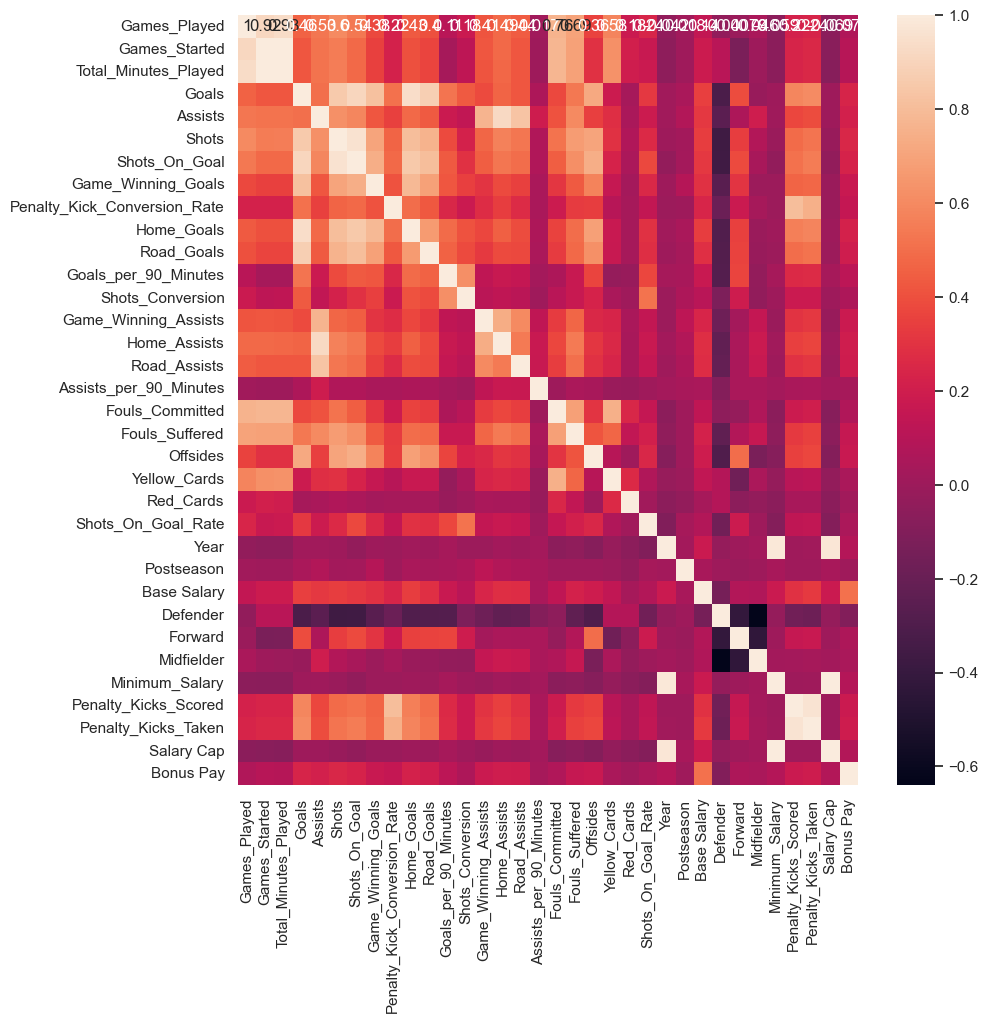

In [278]:
sns.set(rc={'figure.figsize': (10, 10)})

sns.heatmap(stats_salaries_df.corr(), annot=True);

## Modeling 

During the modeling process,  I took a look at the  MSE, RMSE, MAE, and r2. The RMSE, MAE and r2 values held the most significance throughout the process, with the difference in the RMSE and MAE explaining how large some of the errors in  predicting salary are, and the r2 explaining how much of the variance in salary is explained by the features implemented.

### Creating Train Test Split for Base Salary

All modeling will be done on the training data. After choosing the model with the best RMSE and r2, I will evaluate on testing data.

In [279]:
# Splitting our data into independent variable X and dependent variable y
X = stats_salaries_df.drop(columns='Base Salary')
y = stats_salaries_df['Base Salary']

# Running a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Dummy Model

In [280]:
# Instantiating and fitting a dummy, or baseline, regression model
dummy = DummyRegressor()
dummy.fit(X_train, y_train)

DummyRegressor()

In [281]:
# Setting up a kfold to cross-validate the scores from each model
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Dummy Mean Squared Error
dummy_mse = np.mean(cross_val_score(dummy, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))
dummy_mse

-384211411668.69543

In [282]:
# Dummy Root Mean Squared Error
dummy_rmse = np.mean(cross_val_score(dummy, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error'))
dummy_rmse

-613701.2950070875

In [283]:
# Dummy Mean Absolute Error
dummy_mae = np.mean(cross_val_score(dummy, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error'))
dummy_mae

-271259.95152306615

In [284]:
# Creating y_pred to plot and see how dummy predicts
y_pred = dummy.predict(X_train)

# Dummy r2 score
dummy_score = r2_score(y_train, y_pred)
dummy_score

0.0

### Linear Regression
The Linear Regression was not chosen as the final model, as it had a poor r2 score.

#### Instantiating the Model


In [285]:
# Setting up our first model
lr = LinearRegression()
scaler = StandardScaler()
X_train_sc= scaler.fit_transform(X_train)
X_test_sc= scaler.transform(X_test)

lr.fit(X_train_sc, y_train)
y_pred = lr.predict(X_train_sc)

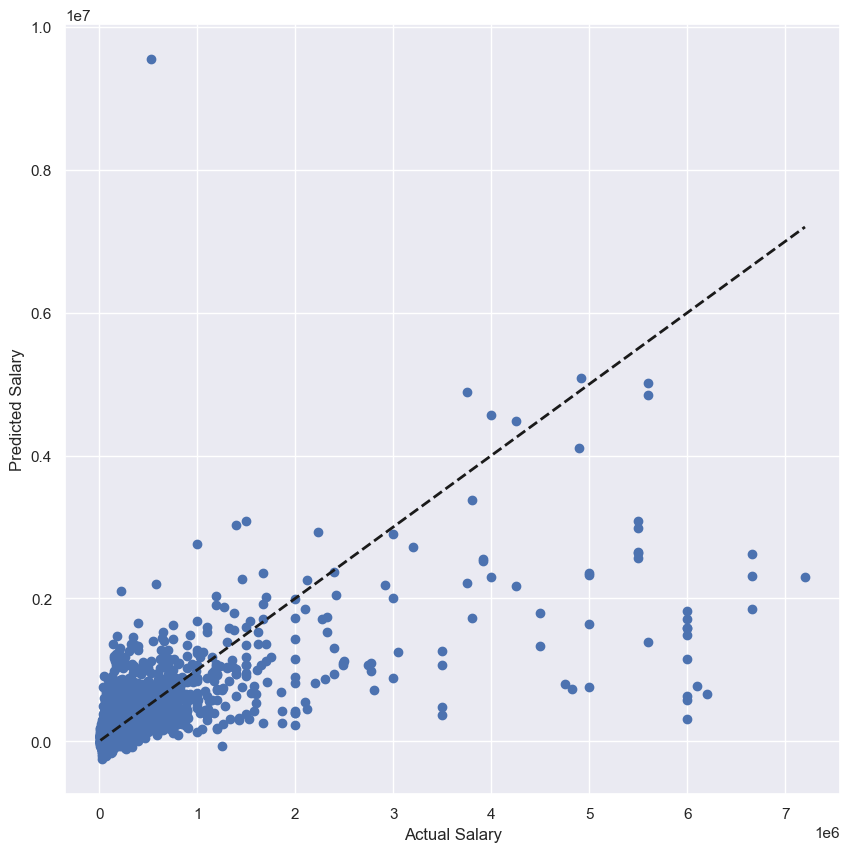

In [286]:
plt.scatter(y_train, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.show()

In [287]:
lr_mse = np.mean(cross_val_score(lr, X_train_sc, y_train, cv=kf, scoring = 'neg_mean_squared_error'))
lr_mse

-251105591116.87335

In [288]:
rmse = np.mean(cross_val_score(lr, X_train_sc, y_train, cv=kf, scoring = 'neg_root_mean_squared_error'))
rmse

-496268.0601943879

In [289]:
lr_mae =  np.mean(cross_val_score(lr, X_train_sc, y_train, cv=kf, scoring = 'neg_mean_absolute_error'))
lr_mae

-196834.22400922532

In [290]:
y_pred_lr = lr.predict(X_train_sc)

lr_score =  np.mean(cross_val_score(lr, X_train_sc, y_train, cv=kf, scoring = 'r2'))
lr_score

0.24642745732457563

#### Data Processing through a Pipeline
All of the models were run through a Pipeline to run Principal Component Analysis. The initial linear regression r2 of XX was far too low.

In [291]:
pipe = Pipeline([
    ('pca', PCA(random_state=42)),
    ('lr', LinearRegression())
])
    

#### Parameter Tuning with GridSearchCV
Utilizing the above Pipeline, I set a parameter grid for GridSearchCV to find the best parameters that returns the highest score.

In [292]:
param_grid = {
    'pca__n_components': [23, 24, 25],
    'pca__copy': [False, True],
    'pca__whiten': [False, True]
}   

In [293]:
grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=kf, return_train_score=True)
grid.fit(X_train_sc, y_train)
print(grid.best_score_)
print(grid.best_params_)

0.2401784375207631
{'pca__copy': False, 'pca__n_components': 25, 'pca__whiten': True}


### Random Forest Model 
The Random Forest Model was chosen as my final model. It produced the highest r2 score with the lowest RMSE and MAE.

#### Instantiating the Model

In [294]:
rf = RandomForestRegressor(random_state=42)

rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [295]:
rf_score = np.mean(cross_val_score(rf, X_train, y_train, cv=5))
rf_score

0.5245985213034848

In [296]:
rf_mse = np.mean(cross_val_score(rf, X_train, y_train, cv=kf, scoring = 'neg_mean_squared_error'))
rf_mse

-179117888156.21857

In [297]:
rf_rmse = np.mean(cross_val_score(rf, X_train, y_train, cv=kf, scoring = 'neg_root_mean_squared_error'))
rf_rmse

-420650.4025757269

In [298]:
rf_mae = np.mean(cross_val_score(rf, X_train, y_train, cv=kf, scoring = 'neg_mean_absolute_error'))
rf_mae

-160023.47771821453

#### Data Processing through a Pipeline

In [299]:
rfpipe = Pipeline([('pca', PCA(random_state=42)),
                    ('rf', RandomForestRegressor(random_state=42))])

#### Parameter Tuning with GridSearchCV

In [300]:
rf_param_grid = {
    'pca__n_components': [10, 20, 30],
    'rf__n_estimators': [10, 50, 100],
    'rf__min_samples_split': [2, 5, 10],
    'rf__criterion': ['squared_error', 'friedman_mse', 'poisson']
}
    

In [301]:
rf_grid = GridSearchCV(rfpipe, rf_param_grid, cv=5, n_jobs=-1, return_train_score=True)
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_)
print(rf_grid.best_params_)

0.565343122214716
{'pca__n_components': 30, 'rf__criterion': 'poisson', 'rf__min_samples_split': 2, 'rf__n_estimators': 100}


In [302]:
rf_param_grid = {
    'pca__n_components': [30, 50, 70],
    'rf__n_estimators': [75, 125, 175],
    'rf__min_samples_split': [3, 5, 7],
    'rf__criterion': ['squared_error', 'friedman_mse', 'poisson']
}
    

In [303]:
rf_grid = GridSearchCV(rfpipe, rf_param_grid, cv=5, n_jobs=-1, return_train_score=True)
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_)
print(rf_grid.best_params_)

/Users/michaelromanski/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
270 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users

0.5719122494085506
{'pca__n_components': 30, 'rf__criterion': 'poisson', 'rf__min_samples_split': 3, 'rf__n_estimators': 175}


In [313]:
rf_param_grid = {
    'pca__n_components': [30, 32, 34],
    'rf__n_estimators': [155, 160, 165],
    'rf__min_samples_split': [2, 3, 4],
    'rf__criterion': ['squared_error', 'friedman_mse', 'poisson']
}

In [314]:
rf_grid = GridSearchCV(rfpipe, rf_param_grid, cv=5, n_jobs=-1, return_train_score=True)
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_)
print(rf_grid.best_params_)

/Users/michaelromanski/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users

0.5720411810474534
{'pca__n_components': 30, 'rf__criterion': 'poisson', 'rf__min_samples_split': 3, 'rf__n_estimators': 160}


In [315]:
rf_bestpipe = Pipeline([('pca', PCA(n_components=30, random_state=42)),
                    ('rf', RandomForestRegressor(n_estimators=160, min_samples_split=3, criterion='poisson', random_state=42))])

In [316]:
rf_bestpipe.fit(X_train, y_train)
y_pred_test = rf_bestpipe.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
r2_test

0.4871857327872071

In [317]:
mse_test = mean_squared_error(y_test, y_pred_test)
mse_test

151644308416.14175

In [318]:
rmse_test = np.sqrt(mse_test)
rmse_test

389415.3417832196

In [319]:
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_test

150159.13808571076

In [321]:
rf_feature_importances = rf_bestpipe.named_steps['rf'].feature_importances_
rf_feature_names = X.columns.tolist()
rf_bestpipe.named_steps['rf'].feature_names = rf_feature_names
print(rf_feature_importances)

[0.09655155 0.49672889 0.00932387 0.04276835 0.00713899 0.0233459
 0.01029013 0.00811629 0.00957068 0.01319114 0.02102764 0.01228063
 0.02181332 0.00976816 0.03040011 0.00954946 0.00792987 0.01098057
 0.01186896 0.00723406 0.0097771  0.00919975 0.00813436 0.0085065
 0.00598347 0.009686   0.01031537 0.04006385 0.00897326 0.02948178]


Principal Component 1: Explained Variance Ratio = 0.98
 Games_Played: -0.00
 Games_Started: -0.00
 Total_Minutes_Played: -0.00
 Goals: -0.00
 Assists: 0.00
 Shots: -0.00
 Shots_On_Goal: -0.00
 Game_Winning_Goals: -0.00
 Penalty_Kick_Conversion_Rate: -0.00
 Home_Goals: -0.00
 Road_Goals: -0.00
 Goals_per_90_Minutes: 0.00
 Shots_Conversion: -0.00
 Game_Winning_Assists: -0.00
 Home_Assists: 0.00
 Road_Assists: -0.00
 Assists_per_90_Minutes: 0.00
 Fouls_Committed: -0.00
 Fouls_Suffered: -0.00
 Offsides: -0.00
 Yellow_Cards: -0.00
 Red_Cards: -0.00
 Shots_On_Goal_Rate: -0.00
 Year: 0.00
 Postseason: 0.00
 Defender: -0.00
 Forward: 0.00
 Midfielder: 0.00
 Minimum_Salary: 0.02
 Penalty_Kicks_Scored: -0.00
 Penalty_Kicks_Taken: 0.00
 Salary Cap: 1.00
 Bonus Pay: 0.01
Principal Component 2: Explained Variance Ratio = 0.02
 Games_Played: 0.00
 Games_Started: 0.00
 Total_Minutes_Played: 0.00
 Goals: 0.00
 Assists: 0.00
 Shots: 0.00
 Shots_On_Goal: 0.00
 Game_Winning_Goals: 0.00
 Penalty_Kick_Conv

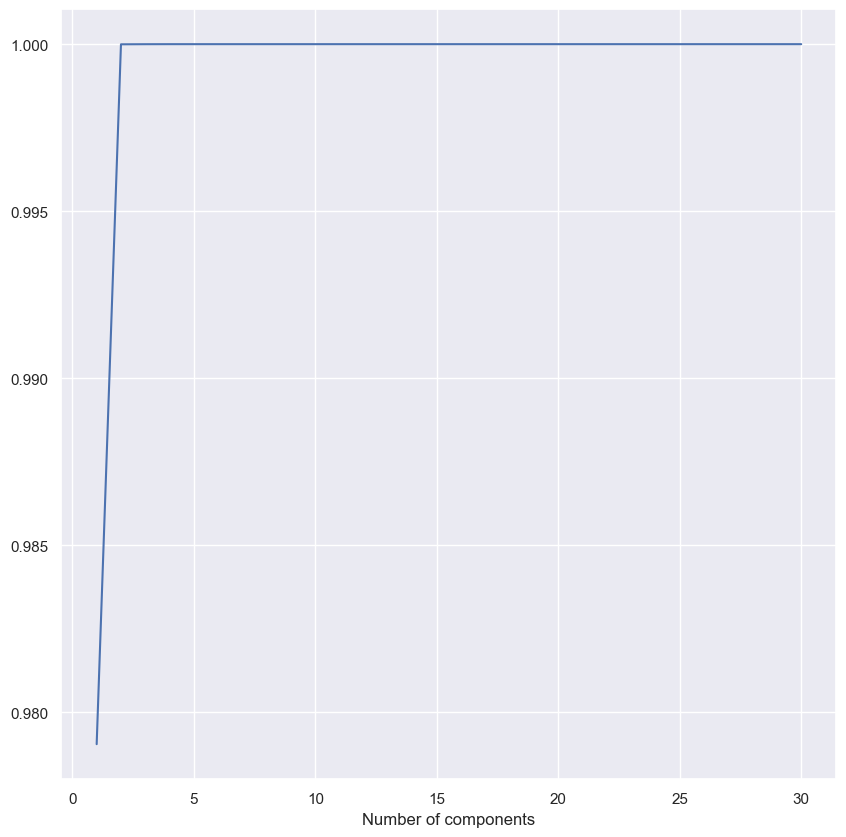

ValueError: Length of values (30) does not match length of index (33)

In [342]:
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error']
r_multi = permutation_importance(rf_bestpipe, X_test, y_test,
                           n_repeats=30, random_state=42, scoring=scoring)

for metric in r_multi:
    print(f"{metric}")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0: 
            print(f"    {rf_feature_names[i]: <8}"   
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

r2
    Bonus Pay0.824 +/- 0.069
    Total_Minutes_Played0.684 +/- 0.020
    Shots   0.411 +/- 0.024
    Shots_On_Goal0.326 +/- 0.021
    Penalty_Kicks_Taken0.239 +/- 0.026
    Salary Cap0.235 +/- 0.034
    Games_Started0.152 +/- 0.011
    Games_Played0.141 +/- 0.011
    Goals   0.131 +/- 0.014
    Penalty_Kicks_Scored0.125 +/- 0.006
    Minimum_Salary0.092 +/- 0.014
    Penalty_Kick_Conversion_Rate0.069 +/- 0.008
    Shots_Conversion0.030 +/- 0.008
    Offsides0.029 +/- 0.009
    Goals_per_90_Minutes0.027 +/- 0.008
    Fouls_Suffered0.023 +/- 0.007
    Road_Goals0.021 +/- 0.006
    Home_Assists0.013 +/- 0.004
    Assists_per_90_Minutes0.007 +/- 0.002
neg_mean_absolute_percentage_error
    Total_Minutes_Played3.883 +/- 0.120
    Shots_On_Goal1.606 +/- 0.074
    Shots   1.575 +/- 0.056
    Games_Started1.355 +/- 0.029
    Salary Cap1.302 +/- 0.086
    Bonus Pay1.007 +/- 0.106
    Games_Played0.933 +/- 0.030
    Minimum_Salary0.834 +/- 0.031
    Penalty_Kicks_Taken0.726 +/- 0.073
    Goal

In [348]:
r = r_multi['r2']
r2_df = pd.DataFrame()
r2_df['Feature'] = rf_feature_names
r2_df['Mean'] = r.importances_mean
r2_df['Range +/-'] = r.importances_std

    
r = r_multi['neg_mean_absolute_percentage_error']
mae_df = pd.DataFrame()
mae_df['Feature'] = rf_feature_names
mae_df['Mean'] = r.importances_mean
mae_df['Range +/-'] = r.importances_std


r = r_multi['neg_root_mean_squared_error']
rmse_df = pd.DataFrame()
rmse_df['Feature'] = rf_feature_names
rmse_df['Mean'] = r.importances_mean
rmse_df['Range +/-'] = r.importances_std

In [349]:
r2_df.to_csv('./data/r2_importances.csv')
mae_df.to_csv('./data/mae_importances.csv')
rmse_df.to_csv('./data/rmse_importances.csv')

### KNearestNeighbors Model
The KnearestNeighbors Model performed better than the Linear Regression, yet still was low in comparision to the random forest.

In [152]:
knn = KNeighborsRegressor()
knn.fit(X_train_sc, y_train)

KNeighborsRegressor()

In [153]:
y_pred_k = knn.predict(X_train_sc)
y_pred_k

array([2688009.408, 176251.592, 581599.2, ..., 192685.0, 70678.2,
       366216.592], dtype=object)

In [169]:
knn_train = knn.score(X_train_sc, y_train)
print(knn_train)


0.6030461241815809


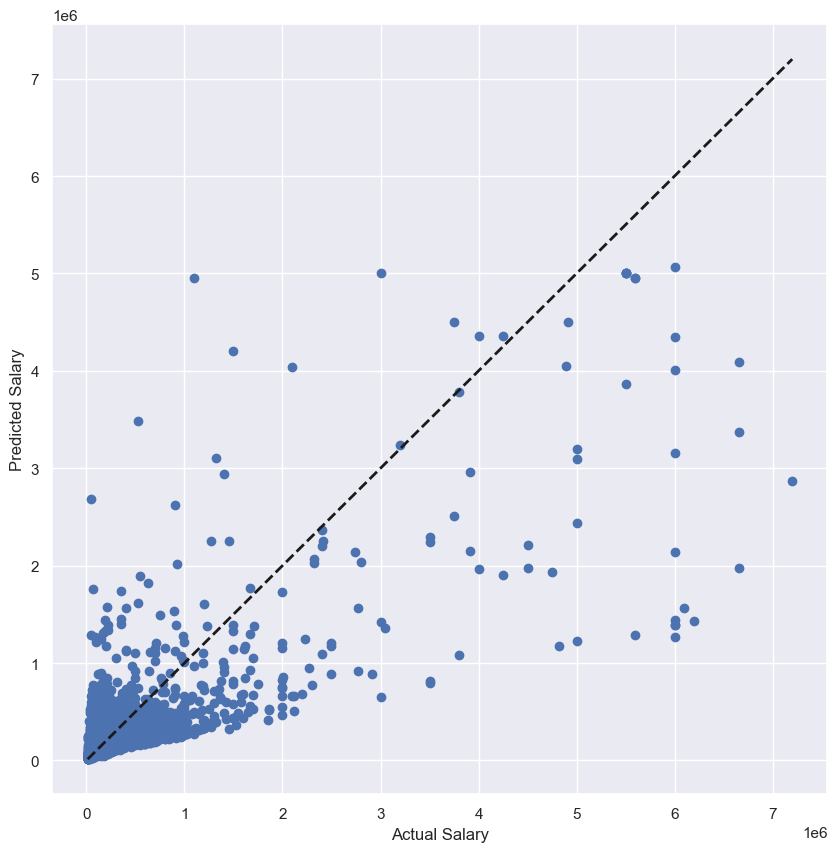

In [155]:
plt.scatter(y_train, y_pred_k)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.show()

In [156]:
knn_mse = np.mean(cross_val_score(knn, X_train_sc, y_train, cv=5, scoring = 'neg_mean_squared_error'))
knn_mse

-237709079990.86288

In [157]:
knn_rmse = np.mean(cross_val_score(knn, X_train_sc, y_train, cv=5, scoring = 'neg_root_mean_squared_error'))
knn_rmse

-485703.11450920405

In [158]:
knn_mae = np.mean(cross_val_score(knn, X_train_sc, y_train, cv=kf, scoring = 'neg_mean_absolute_error'))
knn_mae

-196787.31283144729

In [159]:
knn_mae = np.mean(cross_val_score(knn, X_train_sc, y_train, cv=kf, scoring = 'neg_mean_absolute_error'))
knn_mae

-196787.31283144729

#### Data Processing through a Pipeline


In [160]:
kpipe = Pipeline([('pca', PCA(random_state=42)),
                  ('knn', KNeighborsRegressor())
                 ])
                   

#### Parameter Tuning With GridSearchCV

In [161]:
k_param_grid = {
    'pca__n_components': [5, 10, 15],
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean', 'manhattan']
}

In [162]:
k_grid = GridSearchCV(kpipe, k_param_grid, n_jobs=-1, cv=kf, return_train_score=True)
k_grid.fit(X_train_sc, y_train)
print(k_grid.best_score_)
print(k_grid.best_params_)

0.35864677100547804
{'knn__metric': 'minkowski', 'knn__n_neighbors': 7, 'knn__weights': 'distance', 'pca__n_components': 5}


In [163]:
k_param_grid = {
    'pca__n_components': [7, 10, 13],
    'knn__n_neighbors': [7, 15, 23],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean', 'manhattan']
}

In [164]:
k_grid = GridSearchCV(kpipe, k_param_grid, n_jobs=-1, cv=kf, return_train_score=True)
k_grid.fit(X_train_sc, y_train)
print(k_grid.best_score_)
print(k_grid.best_params_)

0.3572125873769525
{'knn__metric': 'minkowski', 'knn__n_neighbors': 23, 'knn__weights': 'distance', 'pca__n_components': 7}


In [165]:
k_param_grid = {
    'pca__n_components': [3, 5, 7],
    'knn__n_neighbors': [17, 20, 23],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean', 'manhattan']
}

In [166]:
k_grid = GridSearchCV(kpipe, k_param_grid, n_jobs=-1, cv=5, return_train_score=True)
k_grid.fit(X_train_sc, y_train)
print(k_grid.best_score_)
print(k_grid.best_params_)

0.4315074965259755
{'knn__metric': 'minkowski', 'knn__n_neighbors': 23, 'knn__weights': 'distance', 'pca__n_components': 3}


In [167]:
knn_score= np.mean(cross_val_score(knn, X_train_sc, y_train, cv=5))
knn_score

0.3601155272891944